In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.mmd_loss import MMD
#from utils import alter_variables
#from utils import alter_variables_tensor
import math

import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak
import random


from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

#from utils import FindMasks
#from utils import SavePlots
#from utils import plot_regressionFactor

pi = torch.pi

torch.set_num_threads(10)

In [3]:
import numpy as np
import torch
import torch.nn as nn

# Start with checking the Transformer

# For testing: The model must be always on 'eval' mode
# For testing: Never save the gradients (`.detach().cpu()`)

In [4]:
device = torch.device('cpu')

model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paperVersion_AllPartons_Nobtag_autoreg_latentSpace_gaussian_v7-3D-autoreg-7-refPaper2/Transfer_Flow_Paper_AllPartons_Nobtag_autoreg_latentSpace_gaussian_correctPartons_StopPt_scaled_AdamW_min5Jets=False_transfer_flow_2nd_2nd_DiagNormal_NoTransf1_NoBins16_DNN:5_256'

path_to_sample = model_dir + '/sample_few_events.pt'
path_to_sample_allEv = model_dir + '/sample_many_events.pt'
path_to_valid = model_dir + '/valid.pt'
path_to_conf = model_dir + '/config_transfer_flow_2nd_2nd.yaml'

print(path_to_conf)

with open(path_to_conf) as f:
    config = OmegaConf.load(path_to_conf)
        
#path_data = config.input_dataset_test
path_data = config.input_dataset_validation
#print(path_data)
if config.training_params.dtype == "float32":
    dtype = torch.float32
elif config.training_params.dtype == "float64":
    dtype = torch.float64
else:
    dtype = None

/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paperVersion_AllPartons_Nobtag_autoreg_latentSpace_gaussian_v7-3D-autoreg-7-refPaper2/Transfer_Flow_Paper_AllPartons_Nobtag_autoreg_latentSpace_gaussian_correctPartons_StopPt_scaled_AdamW_min5Jets=False_transfer_flow_2nd_2nd_DiagNormal_NoTransf1_NoBins16_DNN:5_256/config_transfer_flow_2nd_2nd.yaml


In [5]:
dict_var = {
  "pt": 0,
  "eta": 1,
  "phi": 2
}

In [6]:
def sampling_print_unscaled(sampledEvent, targetEvent, plotJets, onlyExistElem=False, old_order=False):

    # plot [pt,eta,phi]
    var_name = ['pt', 'eta', 'phi']

    if onlyExistElem:
        check_target_events_withExist = targetEvent[:,plotJets,0] > -5 # here pt (not exist) 
        check_sampled_events_withExist = sampledEvent[:,plotJets,0] > -5 # here exist
        partialMaskReco = torch.logical_and(check_target_events_withExist, check_sampled_events_withExist)

    # keep objects starting from pt=0 (because it was sampled and it was saved without exist flag)
    fullGeneratedEvent_fromPt = sampledEvent[:,plotJets,0:3]   
    maskedGeneratedEvent = fullGeneratedEvent_fromPt[partialMaskReco]

    # keep objects starting from pt=1
    partial_logScaled_reco_sortedBySpanet = targetEvent[:,plotJets,0:3]
    maskedTargetEvent = partial_logScaled_reco_sortedBySpanet[partialMaskReco]
    fig, ax = plt.subplots(1, 6, figsize=(21,5), dpi=100)
    
    fig.suptitle(f'[lep, MET, tlep, thad, H]', fontsize=20)
    if old_order:
        fig.suptitle(f'[lep, MET, H, thad, tlep]', fontsize=20)

    ranges2d = [(0, 350), (-5, 5), (-3.14, 3.14)]
    ranges1d = [(-300, 300), (-5, 5), (-3.14, 3.14)]

    if plotJets == 0:
        title = 'lepton'
    elif plotJets == 1:
        title = 'MET'
    else:
        title = f'jet = {plotJets}'

    # check pt,eta,phi distrib
    for plot_var in range(3):

        diff_generatedAndTarget = (maskedGeneratedEvent[:,plot_var] - maskedTargetEvent[:,plot_var])
        ax[2*plot_var].hist(diff_generatedAndTarget.detach().cpu().numpy(), range=ranges1d[plot_var], bins=20, histtype='step', color='b', stacked=False, fill=False)
        ax[2*plot_var].set_xlabel(f'{var_name[plot_var]}_generated - {var_name[plot_var]}_target')
        ax[2*plot_var].set_title(f'{title}')

        h = ax[2*plot_var + 1].hist2d(maskedGeneratedEvent[:,plot_var].detach().cpu().numpy(),
                      maskedTargetEvent[:,plot_var].detach().cpu().numpy(),
                      bins=100, range=[ranges2d[plot_var],ranges2d[plot_var]], cmin=1)
        fig.colorbar(h[3], ax=ax[2*plot_var + 1])
        ax[2*plot_var + 1].set_xlabel(f'sampled {var_name[plot_var]}')
        ax[2*plot_var + 1].set_ylabel(f'target {var_name[plot_var]}')
        ax[2*plot_var + 1].set_title(f'{title}')

    fig.tight_layout()

In [7]:
def sampling_print_oneEvent_oneVar(sampledEvent, targetEvent,
                                   evNo, var='pt', noObjs=12, range_x=(0,600), difference=False, old_order=False):
    
    no_rows = int(noObjs / 4) 
    fig, axs = plt.subplots(no_rows, 4, figsize=(25, 4*no_rows))
    fig.suptitle(f'Ev = {evNo} \n [lep, MET, tlep, thad, H]', fontsize=20)
    if old_order:
        fig.suptitle(f'Ev = {evNo} \n [lep, MET, H, thad, tlep]', fontsize=20)

    for i in range(no_rows):    
        for j in range(4):
            if 4*i+j == 0:
                title = 'lepton'
            elif 4*i+j == 1:
                title = 'MET'
            else:
                title = f'jet {4*i+j}'
        
            if difference:
                axs[i][j].hist(sampledEvent[evNo, :, 4*i+j, dict_var[var]].numpy() - targetEvent[evNo, 4*i+j, dict_var[var]].numpy(),
                               bins=100, range=range_x, label="difference");
            else:
                axs[i][j].hist(sampledEvent[evNo, :, 4*i+j, dict_var[var]].numpy(), bins=100, range=range_x, label="Sampled");
                axs[i][j].axvline(targetEvent[evNo, 4*i+j, dict_var[var]].numpy(), c="red", label="Truth")
            axs[i][j].set_xlabel(f"{title} {var}", fontsize=12)
            axs[i][j].legend()
    fig.tight_layout()

In [8]:
def sampling_print_oneEvent_2Dcorr(sampledEvent, targetEvent, evNo, jetNo, var='pt',
                                   noObjs=12, range_x=(0, 600), xlabel='x', ylabel='y', old_order=False):
    
    fig, axs = plt.subplots(9, 4, figsize=(25, 40))
    fig.suptitle(f'Ev = {evNo} \n [lep, MET, tlep, thad, H]', fontsize=20)
    if old_order:
        fig.suptitle(f'Ev = {evNo} \n [lep, MET, H, thad, tlep]', fontsize=20)

    if jetNo == 0:
        title = 'lepton'
    elif jetNo == 1:
        title = 'MET'
    else:
        title = f'jet {jetNo}'

    for i in range(9):
        for j in range(4):
            var2 = (4*i + j) % 3
            jetNo2 = int((4*i + j) / 3)

            if jetNo2 == 0:
                title2 = 'lepton'
            elif jetNo2 == 1:
                title2 = 'MET'
            else:
                title2 = f'jet {jetNo2}'

            if var2 == 0:
                minVal=0
                maxVal=600
            else:
                minVal = -3
                maxVal = 3

            
            axs[i][j].hist2d(sampledEvent[evNo, :, jetNo, dict_var[var]].numpy(),
                             sampledEvent[evNo, :, jetNo2, var2].numpy(),                          
                             bins=1000, range=[range_x, (minVal, maxVal)], cmin=1, cmap="viridis");
            
            axs[i][j].plot(targetEvent[evNo, jetNo, dict_var[var]].numpy(),
                              targetEvent[evNo, jetNo2, var2].numpy(),
                              'rx', label="Truth")
            
            axs[i][j].set_xlabel(f"{title} {var}", fontsize=12)
            axs[i][j].set_ylabel(f"{title2} {list(dict_var.keys())[var2]}", fontsize=12)
            axs[i][j].legend()

    fig.tight_layout()

In [9]:
def sampling_print_manyEvents__oneJet_oneVar(sampledEvent, targetEvent, listEv, jetNo,
                                               var='pt', noObjs=12, range_x=(0,600), difference=False, old_order=False):

    no_rows = int(len(listEv) / 4) + 1
    fig, axs = plt.subplots(no_rows, 4, figsize=(25, 4*no_rows))
    fig.suptitle(f'[lep, MET, tlep, thad, H]', fontsize=20)
    if old_order:
        fig.suptitle(f'[lep, MET, H, thad, tlep]', fontsize=20)

    for i in range(no_rows):
        for j in range(4):
            if 4*i + j >= len(listEv):
                break
            evNo = listEv[4*i + j]
            if difference:
                axs[i][j].hist(sampledEvent[evNo, :, jetNo, dict_var[var]].numpy() - targetEvent[evNo, jetNo, dict_var[var]].numpy(),
                               bins=100, range=range_x, label="difference");
            else:
                axs[i][j].hist(sampledEvent[evNo, :, jetNo, dict_var[var]].numpy(), bins=100, range=range_x, label="Sampled");
                axs[i][j].axvline(targetEvent[evNo, jetNo, dict_var[var]].numpy(), c="red", label="Truth")
            axs[i][j].set_xlabel(f"Jet {jetNo} {var}", fontsize=12)
            axs[i][j].legend()
    fig.tight_layout()

In [10]:
def sampling_print_manyEvents__oneJet_allVar(sampledEvent, targetEvent, listEv, jetNo,
                                             range_x=[(0,600), (-3,3), (-3,3)], noObjs=12, difference=False, old_order=False):

    no_rows = len(listEv)
    fig, axs = plt.subplots(no_rows, 3, figsize=(25, 4*no_rows))
    fig.suptitle(f'[lep, MET, tlep, thad, H]', fontsize=20)
    if old_order:
        fig.suptitle(f'[lep, MET, H, thad, tlep]', fontsize=20)

    

    for i in range(no_rows):
        for j in range(3):
            evNo = listEv[i]

            if difference:
                axs[i][j].hist(sampledEvent[evNo, :, jetNo, j].numpy() - targetEvent[evNo, jetNo, j].numpy(),
                               bins=100, range=range_x[j], label="difference");
            else:
                axs[i][j].hist(sampledEvent[evNo, :, jetNo, j].numpy(), bins=100, range=range_x[j], label="Sampled");
                axs[i][j].axvline(targetEvent[evNo, jetNo, j].numpy(), c="red", label="Truth")
            axs[i][j].set_xlabel(f"Jet {jetNo} {list(dict_var.keys())[j]}", fontsize=12)
            axs[i][j].legend()
    fig.tight_layout()

In [11]:
def unscale_var(log_mean_reco, log_std_reco, scaled_target):
    # exist on first position
    unscaled_target = torch.clone(scaled_target) # keep the same exist=1
    
    unscaled_target[:,:,1:4] = scaled_target[:,:,1:4]*log_std_reco + log_mean_reco
    unscaled_target[:,:,1] = torch.exp(unscaled_target[:,:,1]) - 1 # unscale pt

    mask_nonExist = (scaled_target[...,0] == 0).unsqueeze(dim=2)
    unscaled_target[...,1:4] = torch.where(mask_nonExist, -5, unscaled_target[...,1:4])

    return unscaled_target

# First VALID - ORDRING IMPORTANT

In [12]:
sampledValid = torch.load(path_to_valid, map_location=device)
 
print(sampledValid.shape)


torch.Size([178176, 31, 12, 3])


In [12]:
for i in range(12):
    sampling_print_unscaled(sampledValid[:,1], sampledValid[:,0], plotJets=i, onlyExistElem=True)

NameError: name 'sampledValid' is not defined

# ORDERING IMPORTANT

In [13]:
#sampledEvent = torch.load(path_to_sample, map_location=device)
sampledAllEvent = torch.load(path_to_sample_allEv, map_location=device)

#print(sampledEvent.shape)
print(sampledAllEvent.shape)

torch.Size([1792000, 31, 12, 3])


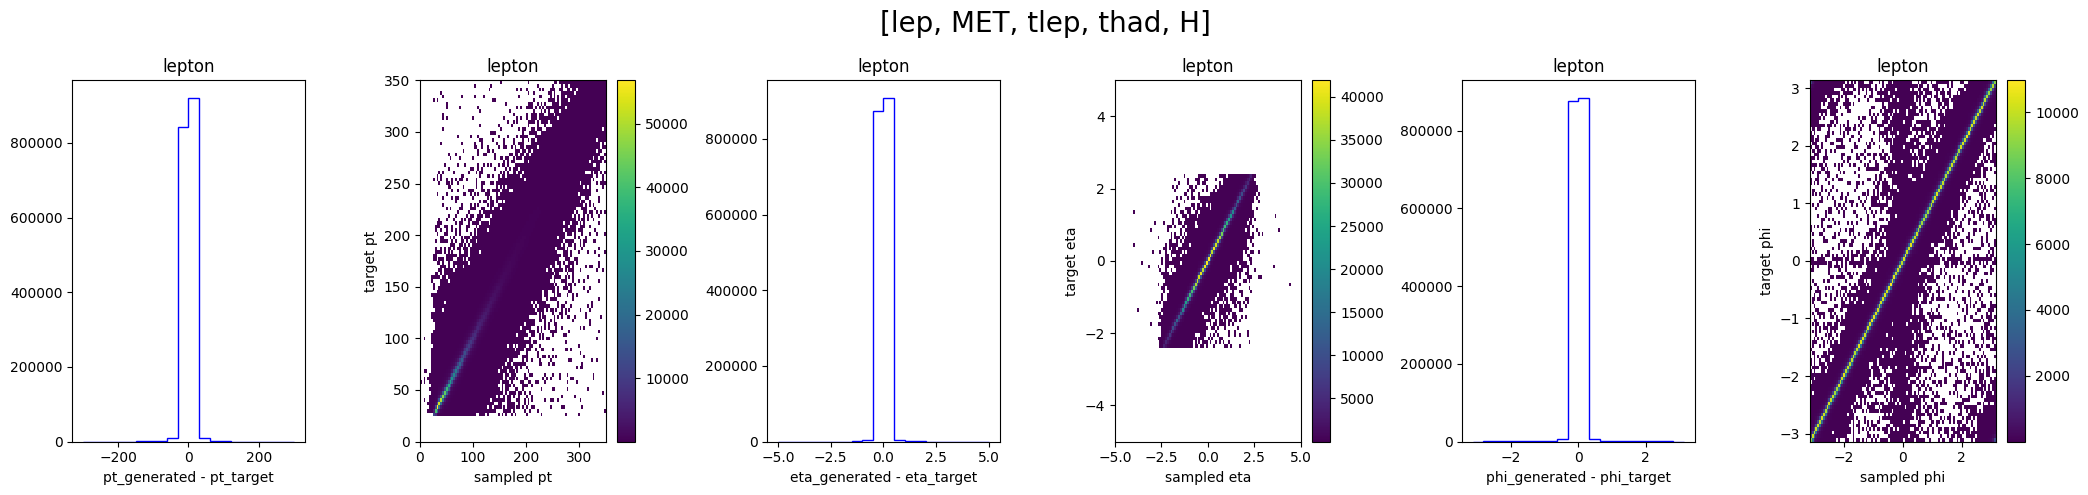

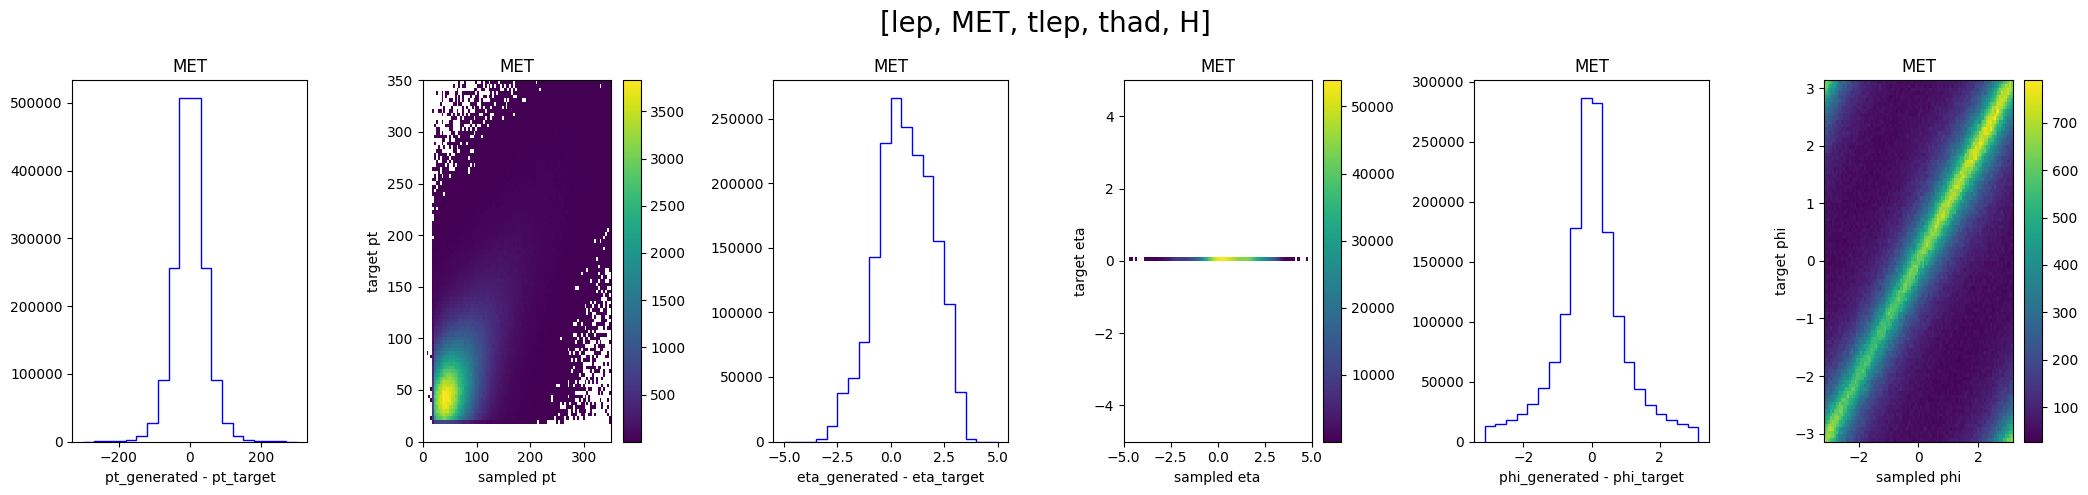

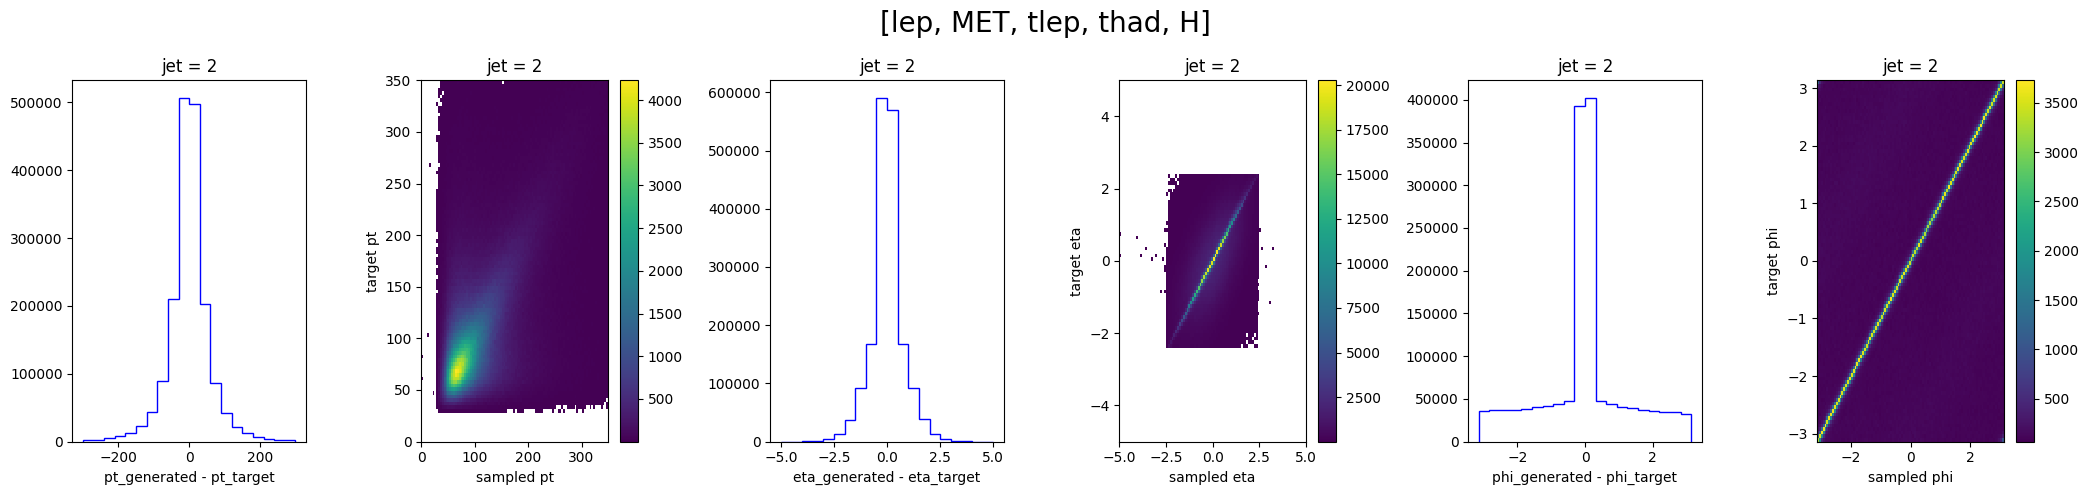

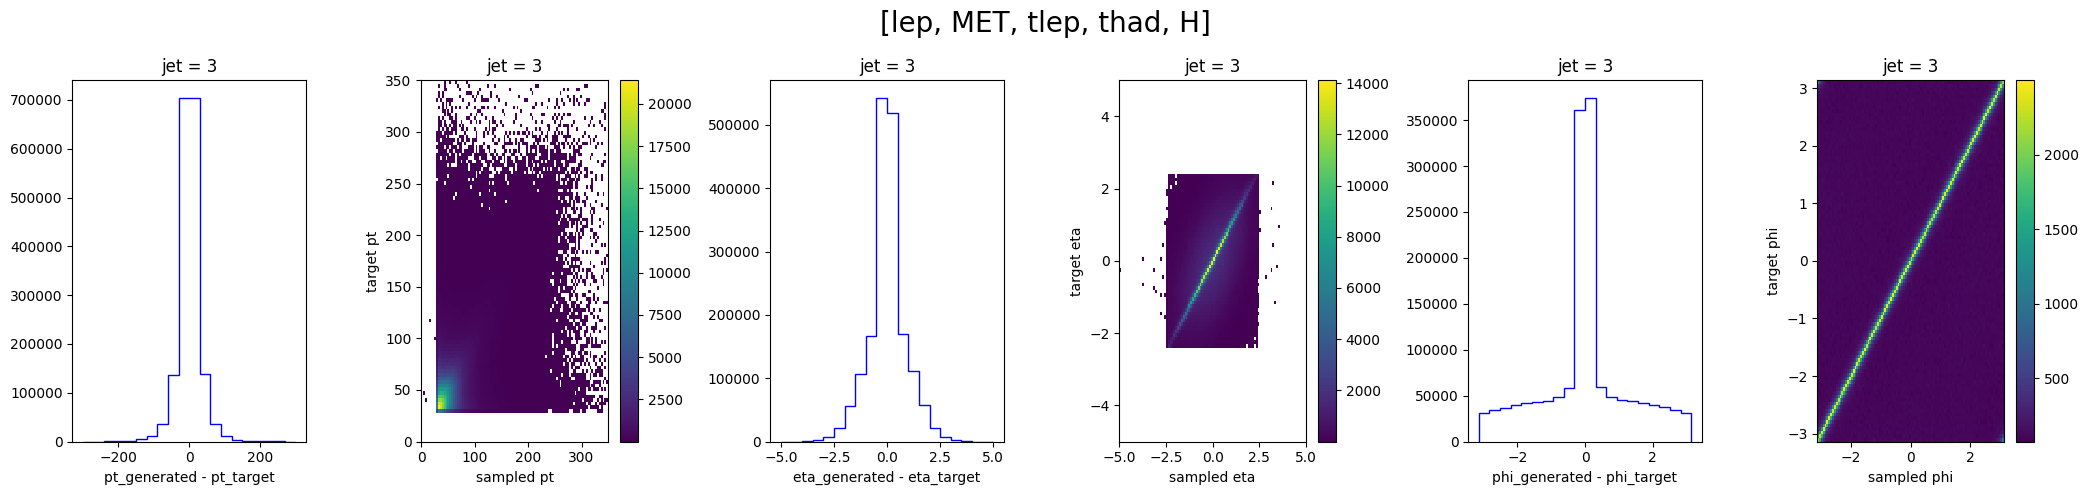

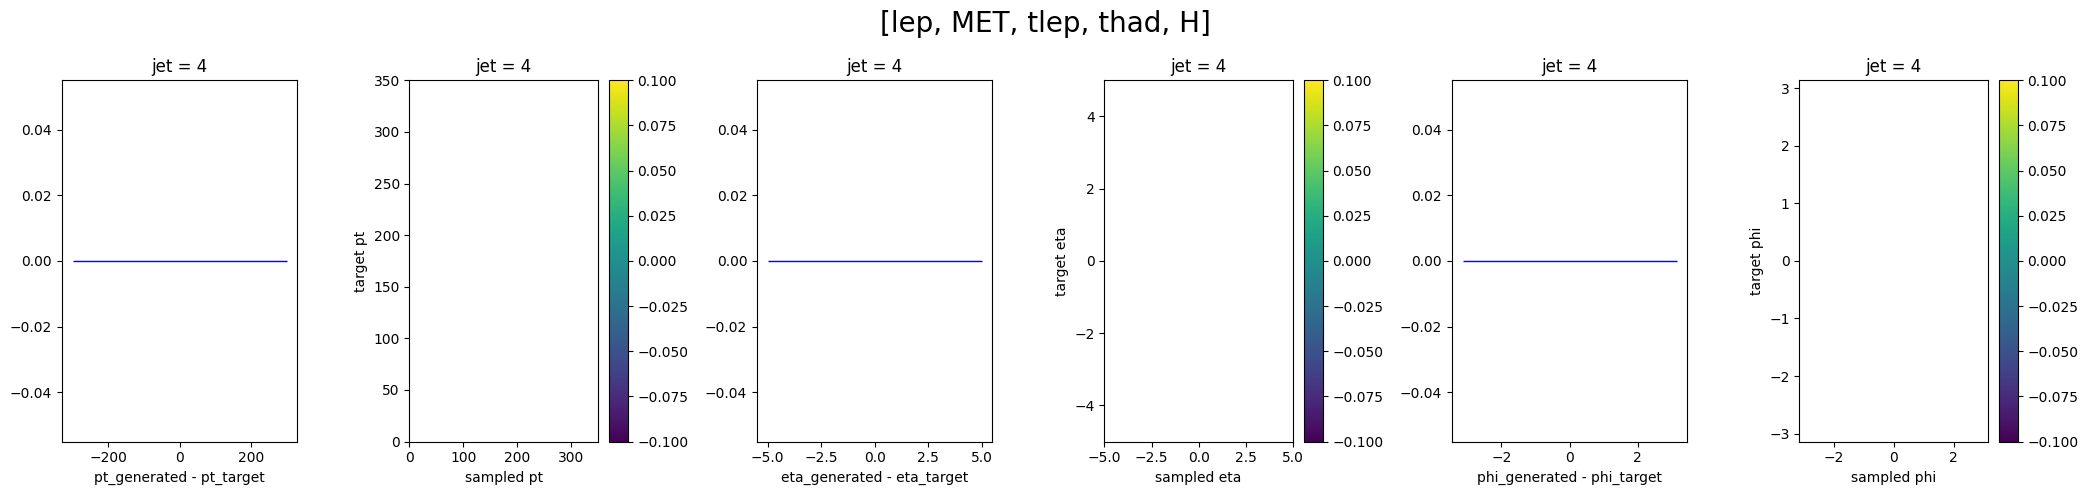

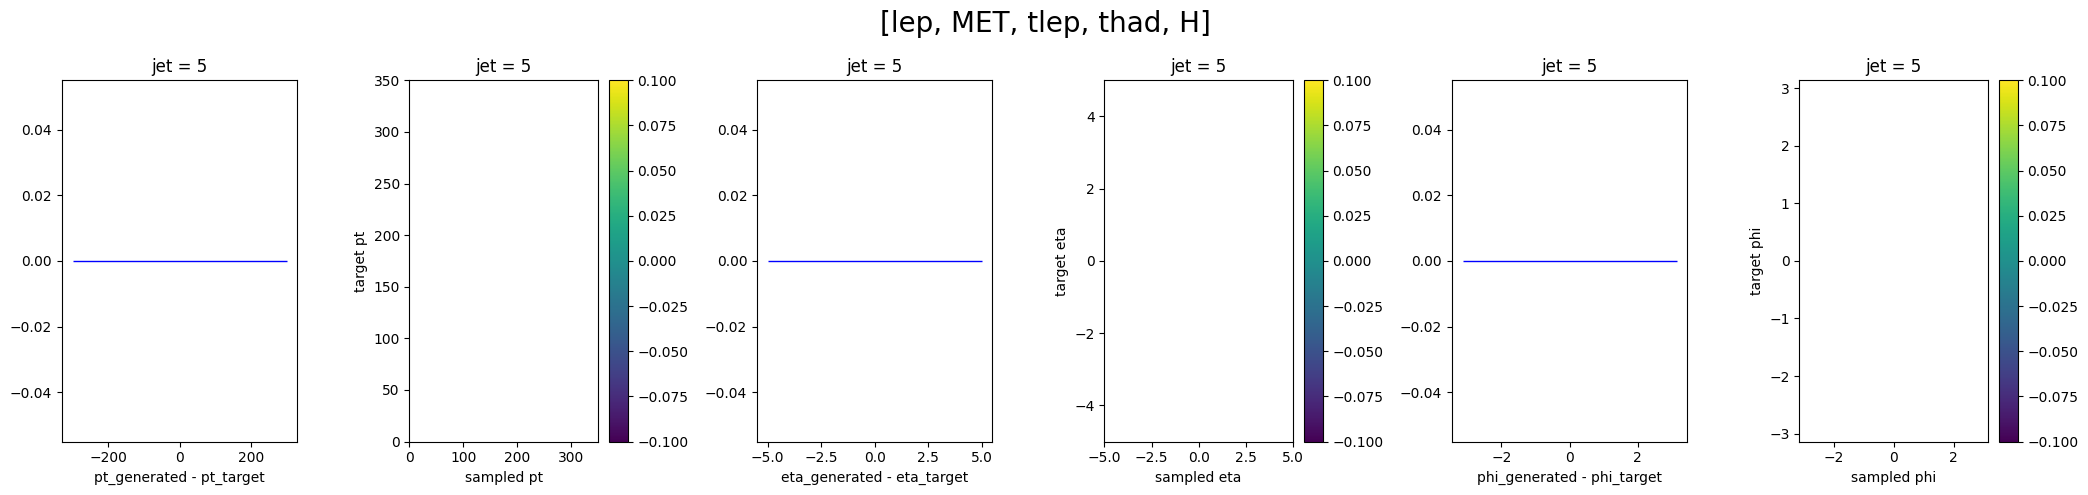

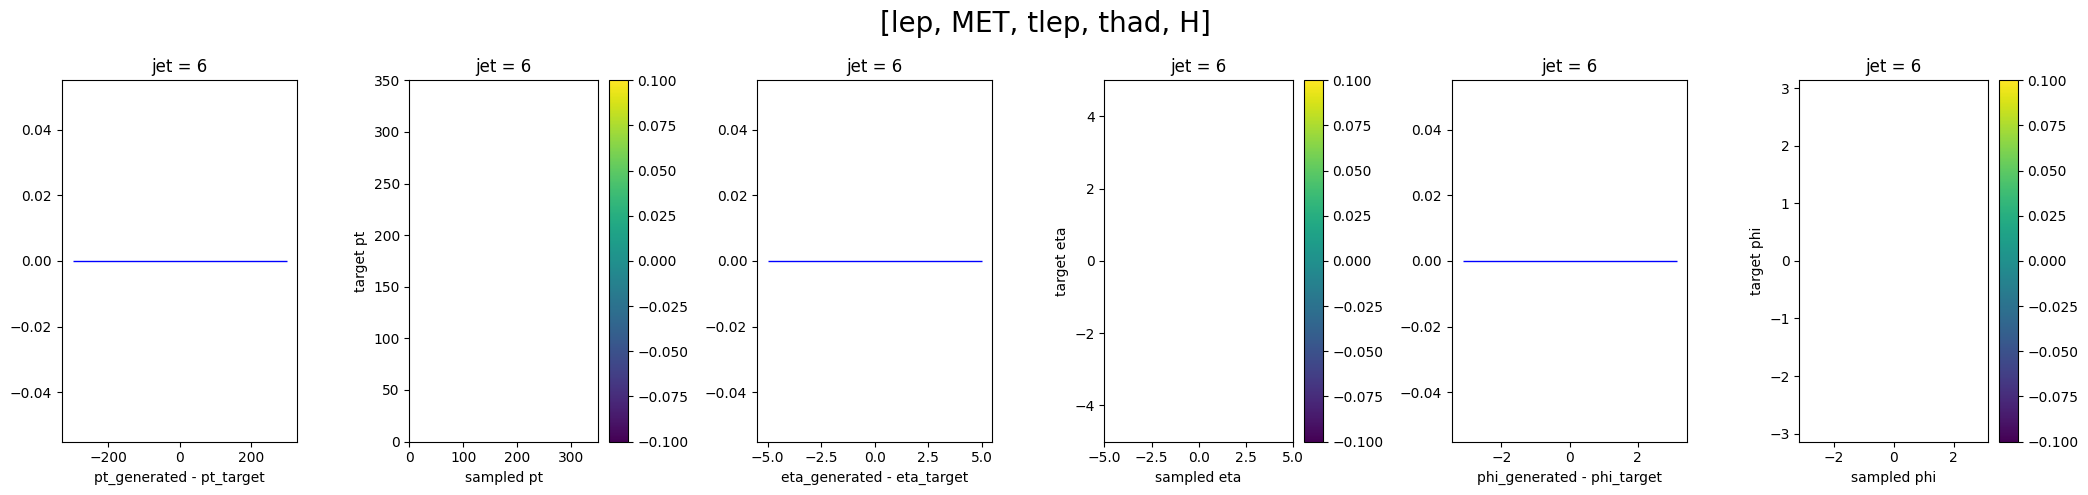

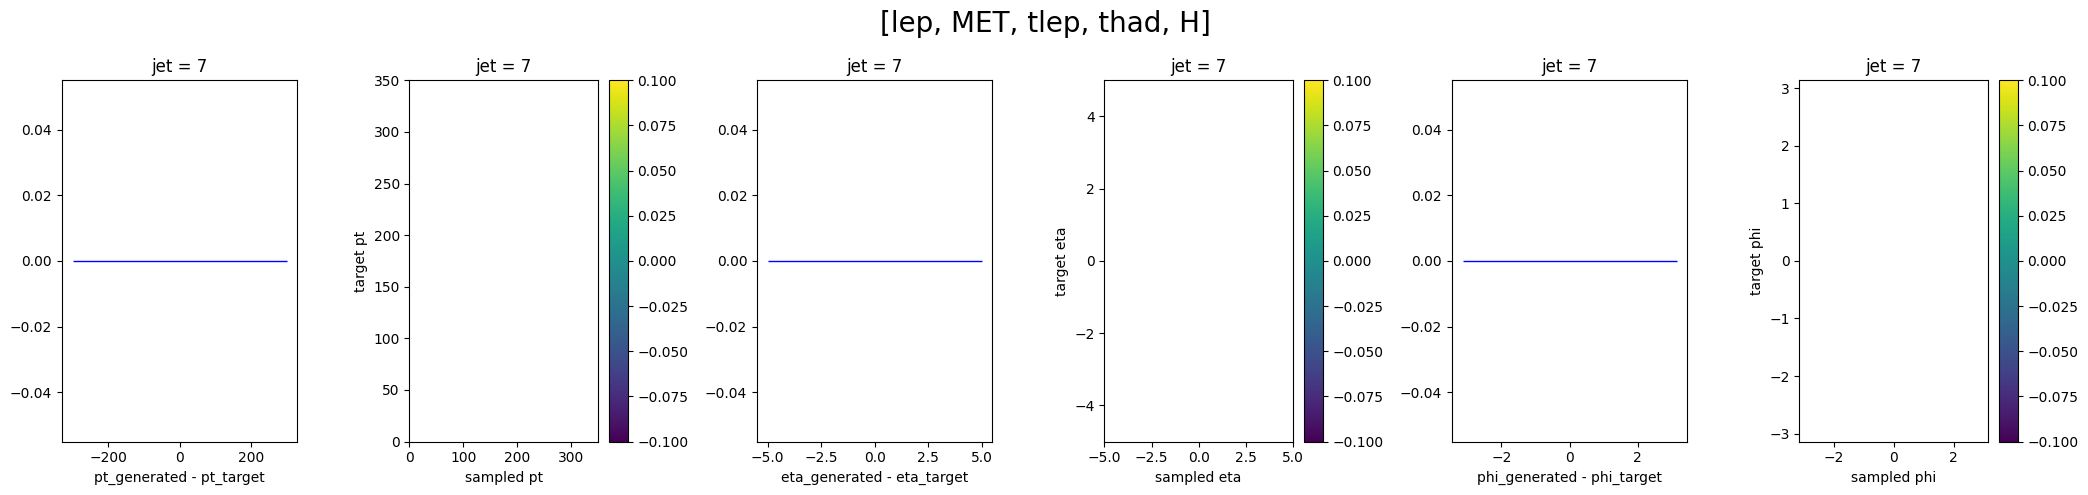

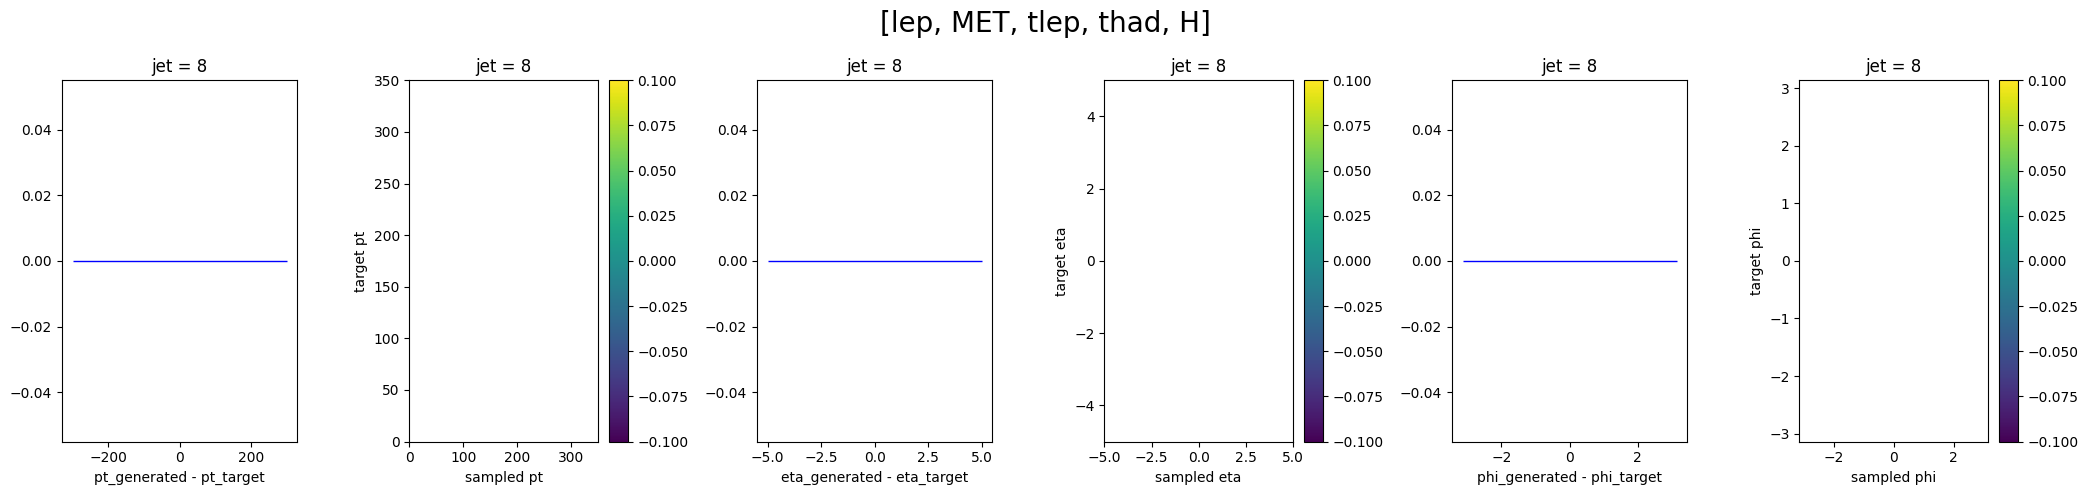

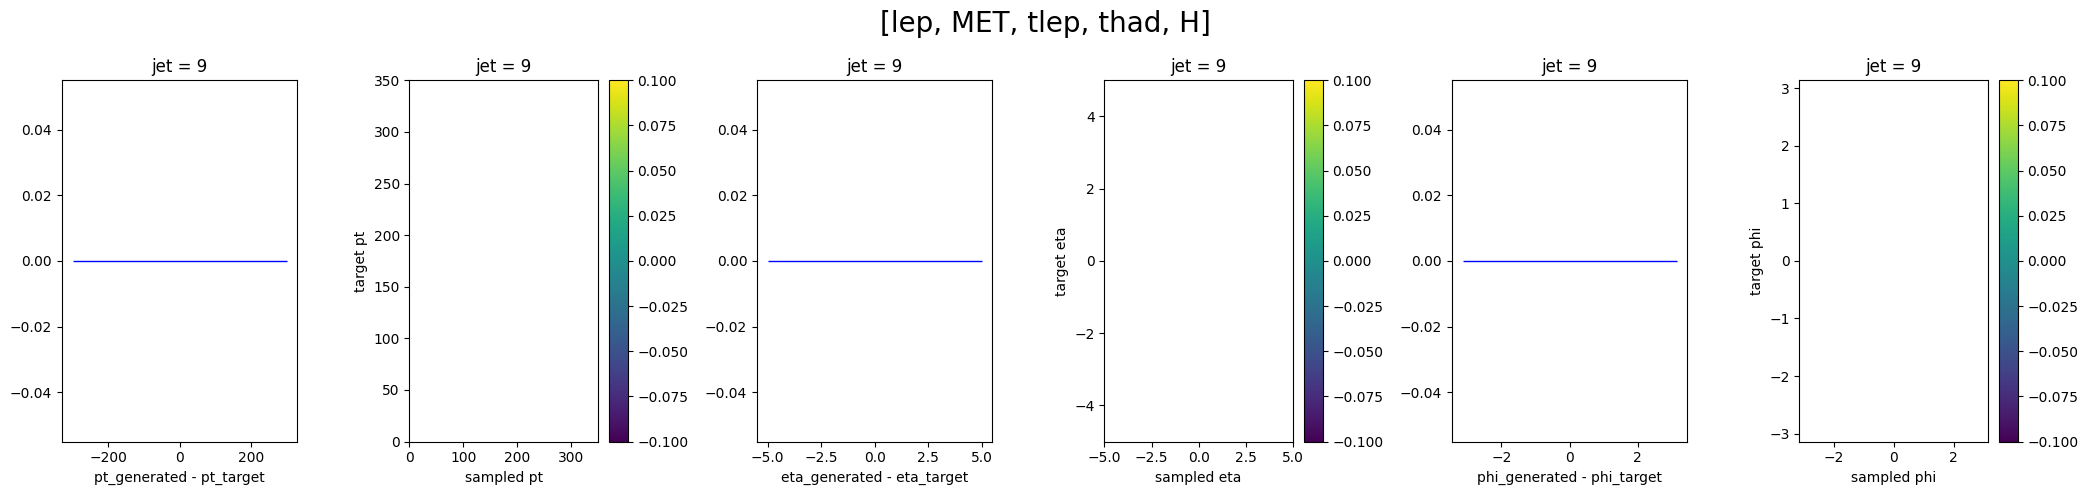

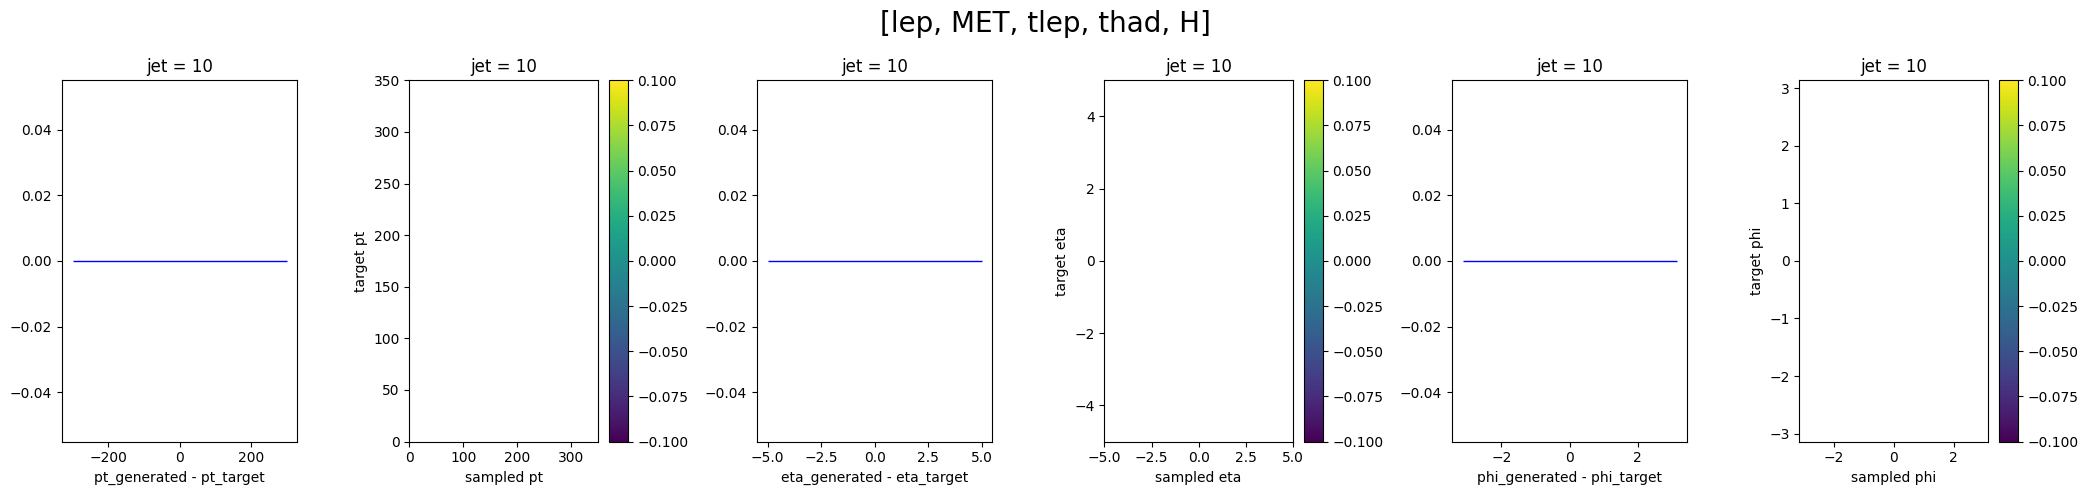

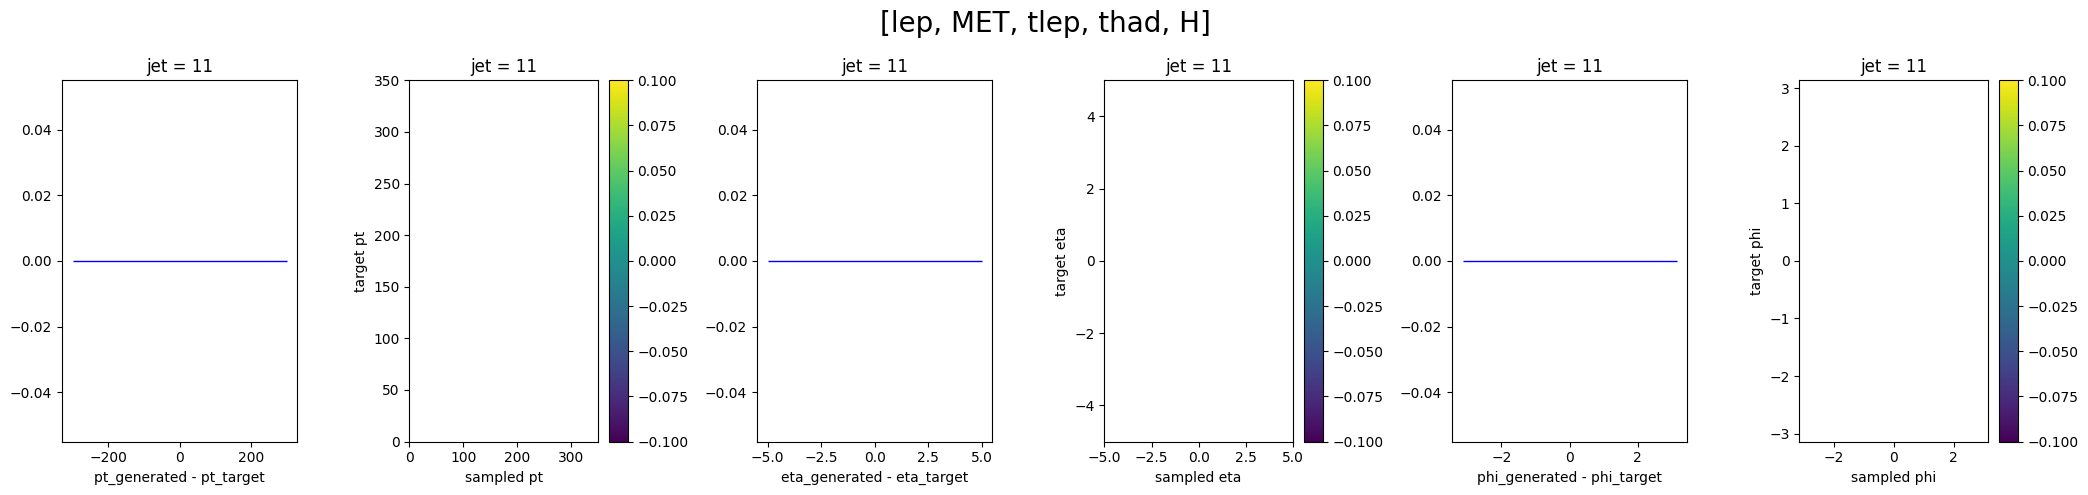

In [14]:
for i in range(12):
    sampling_print_unscaled(sampledAllEvent[:,1], sampledAllEvent[:,0], plotJets=i, onlyExistElem=True)

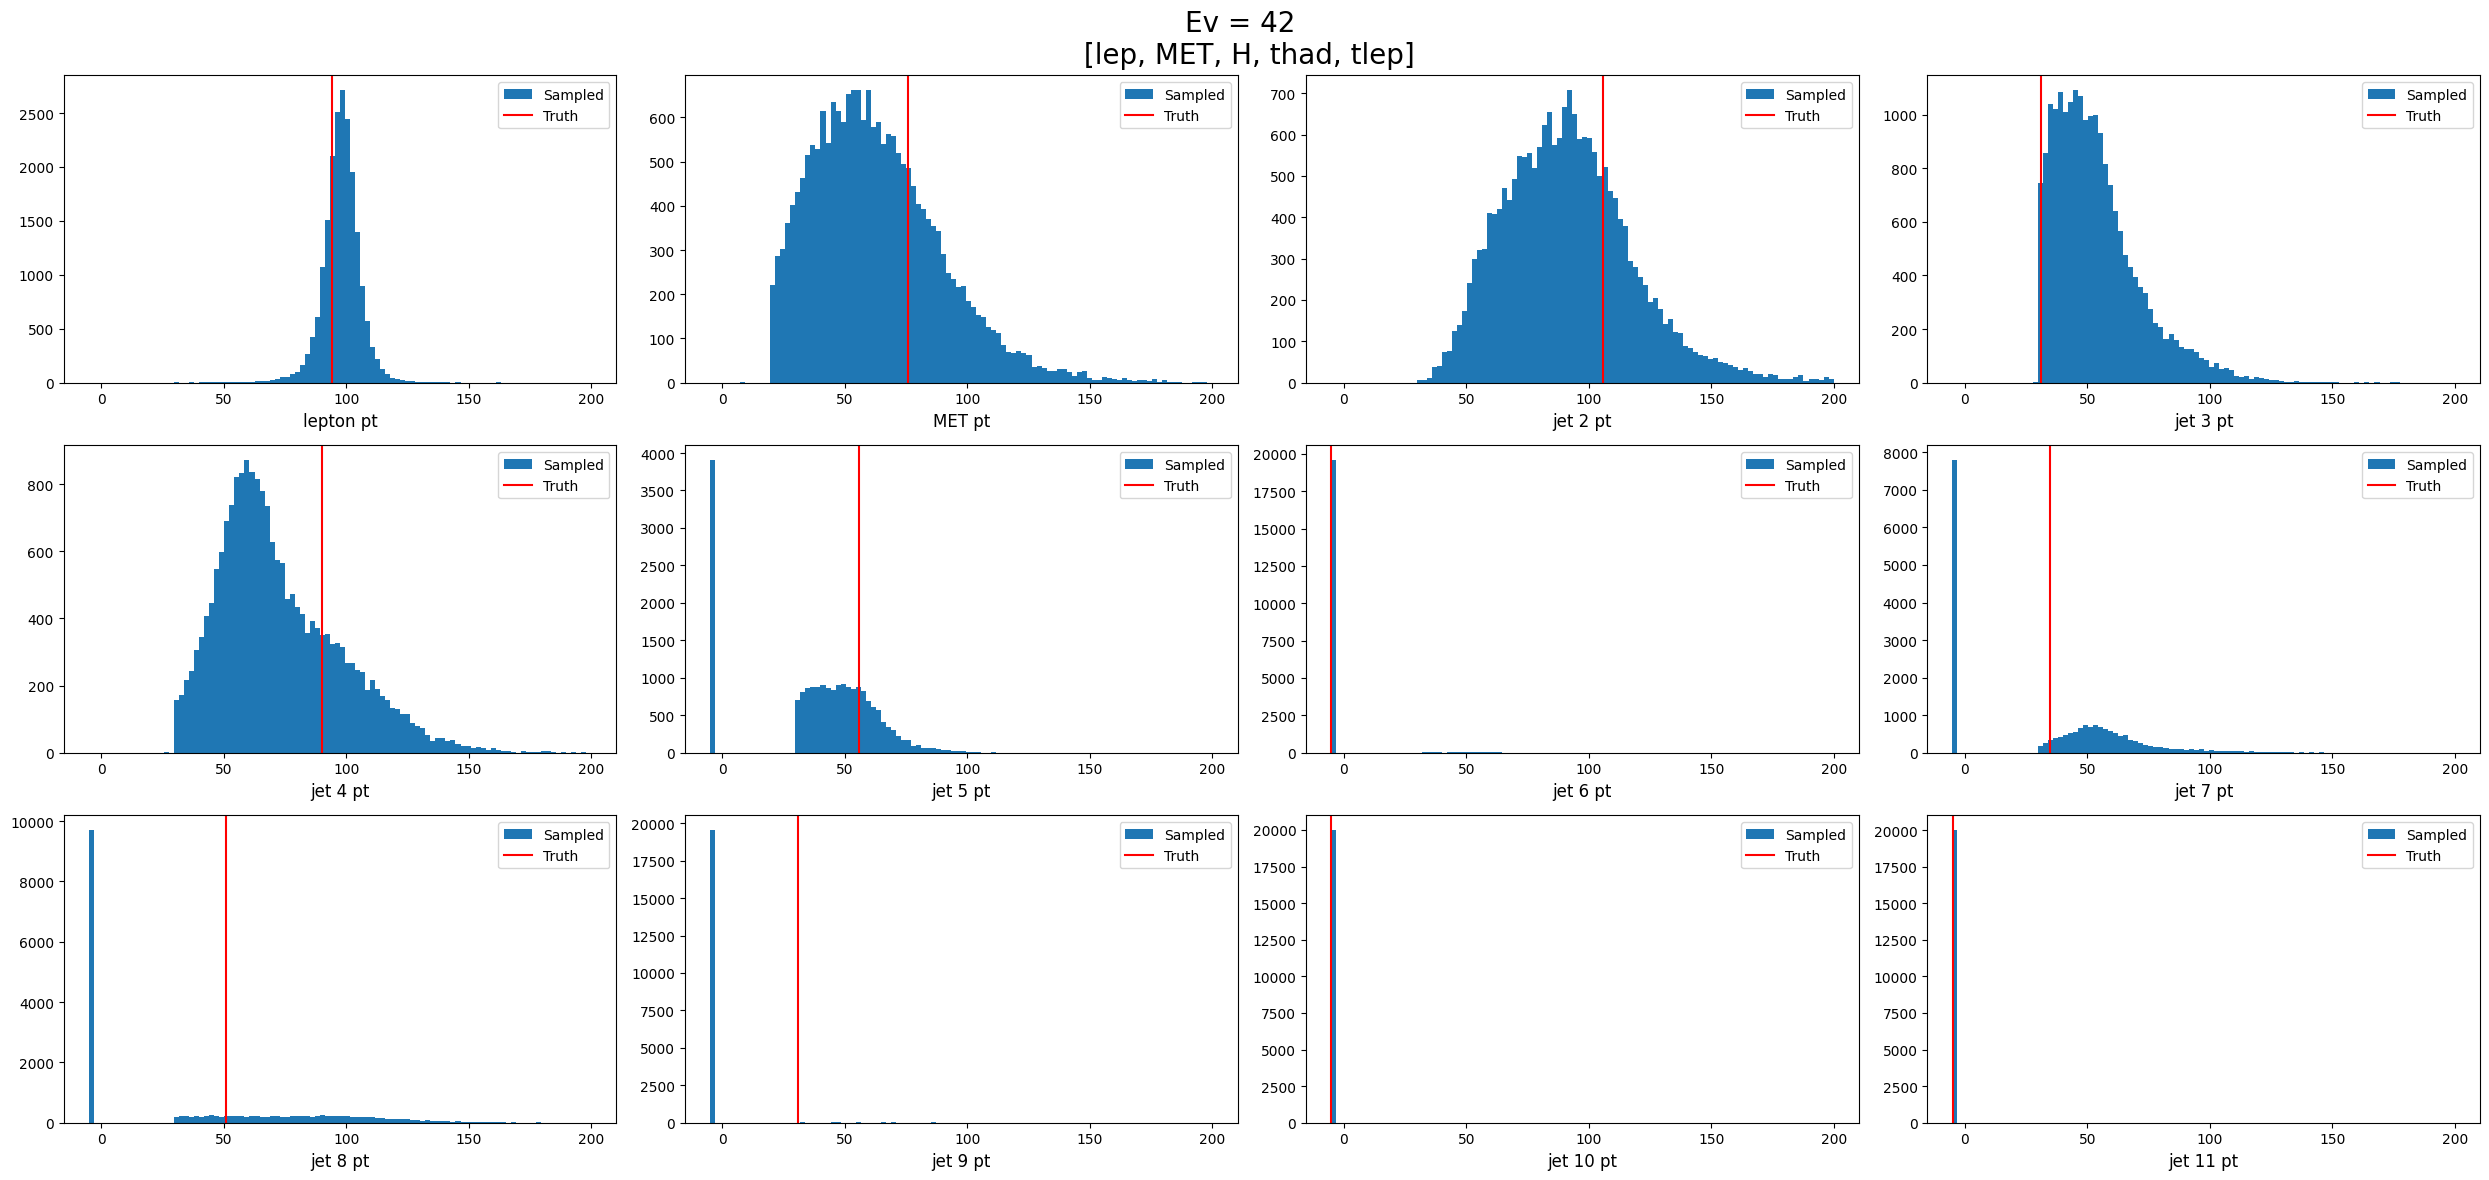

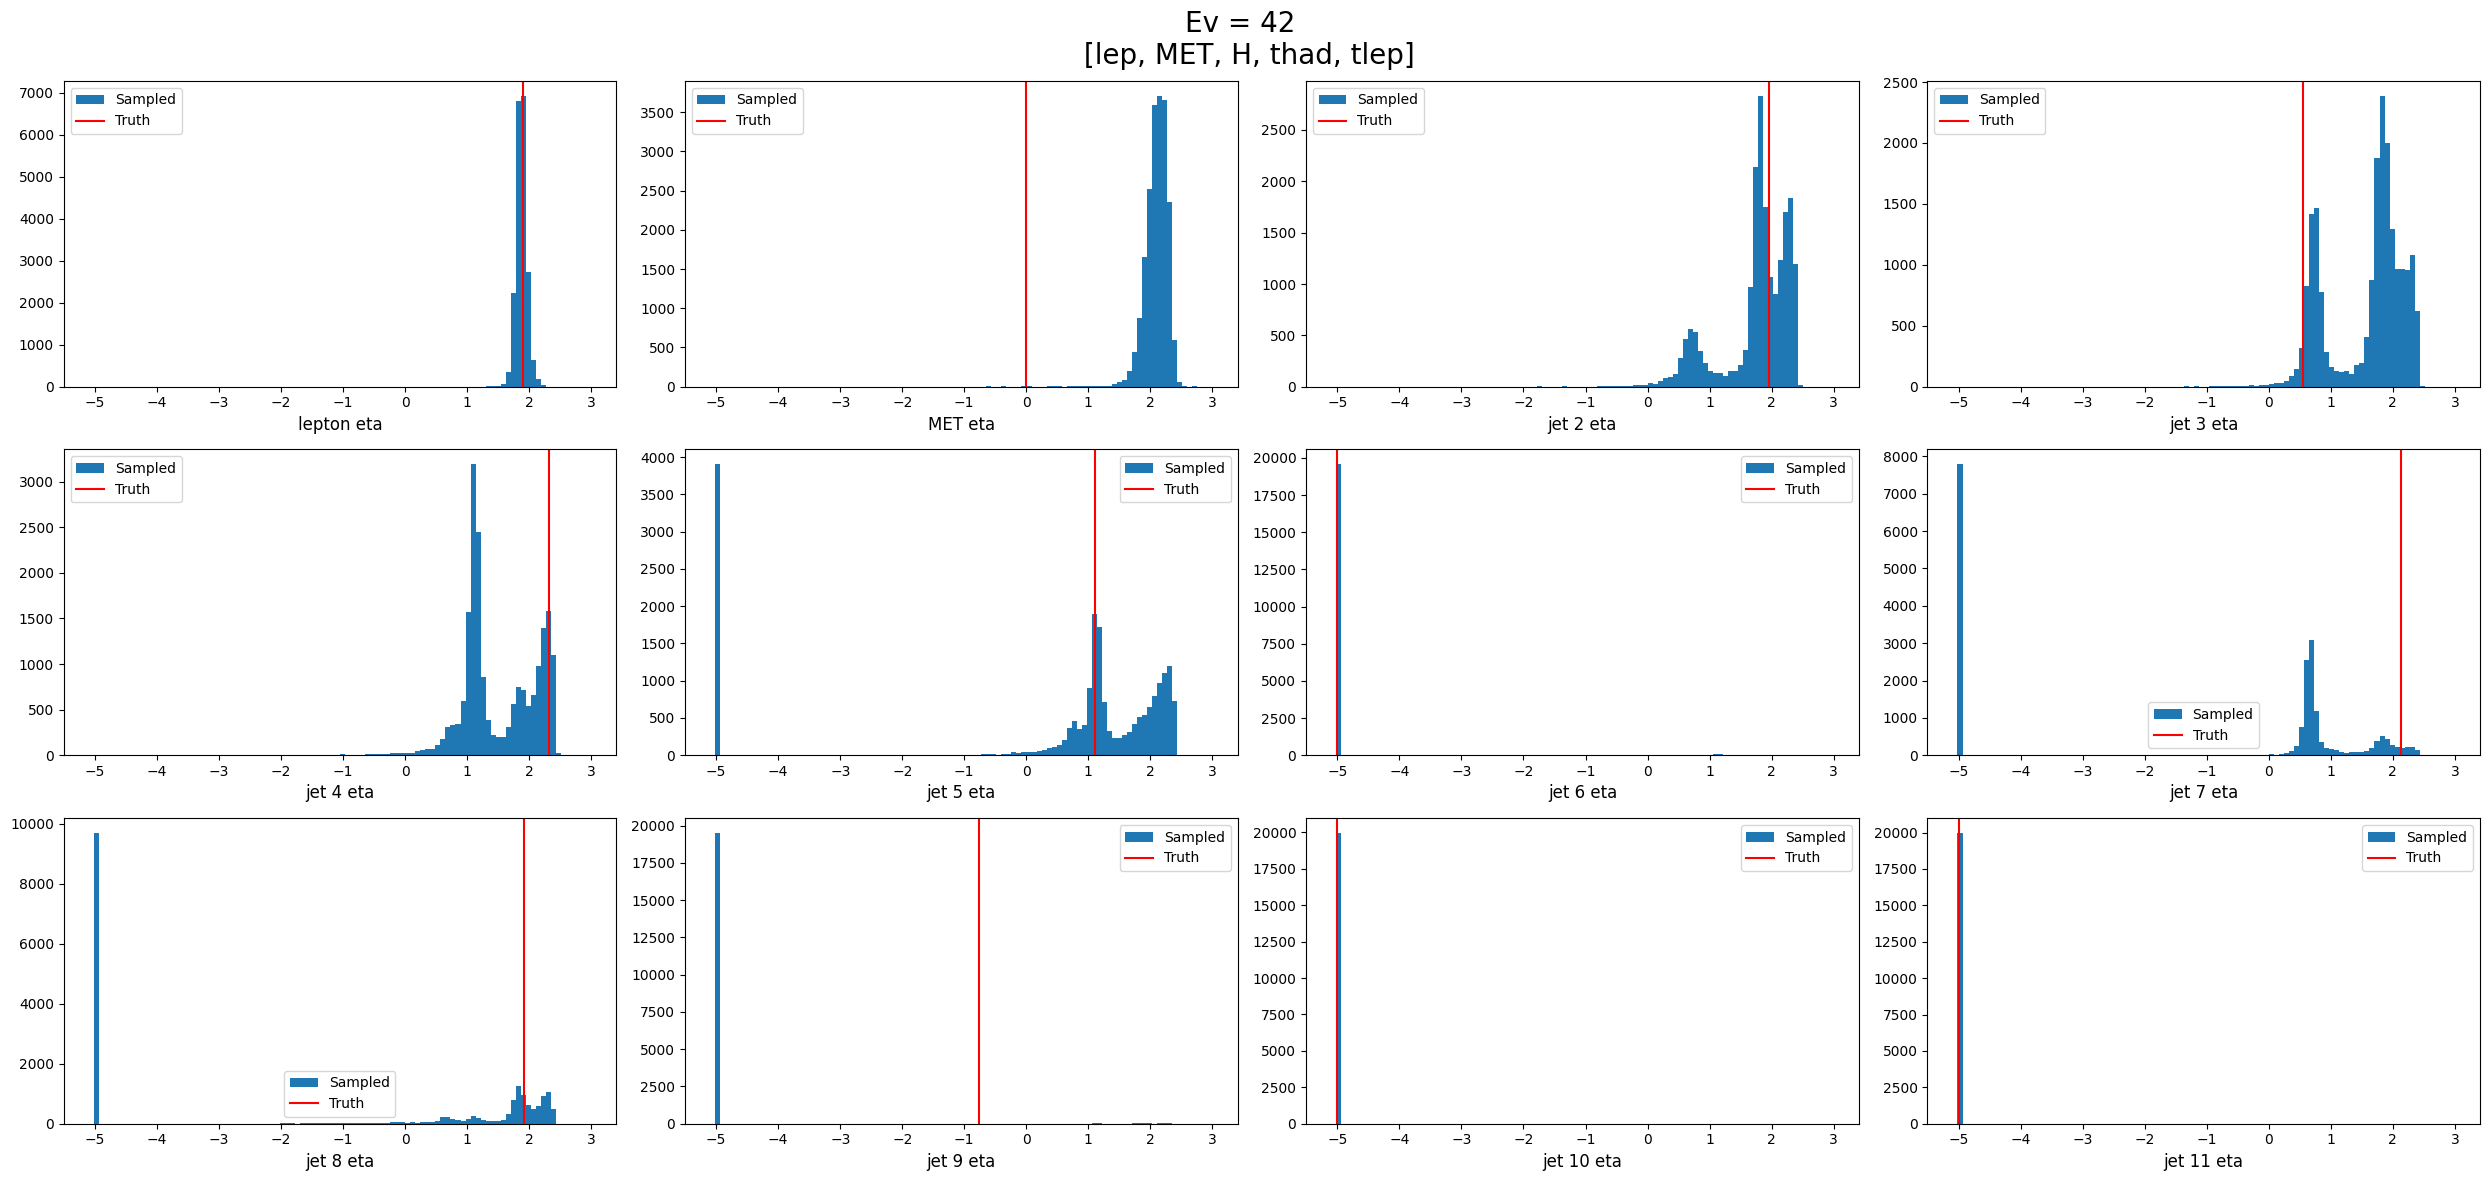

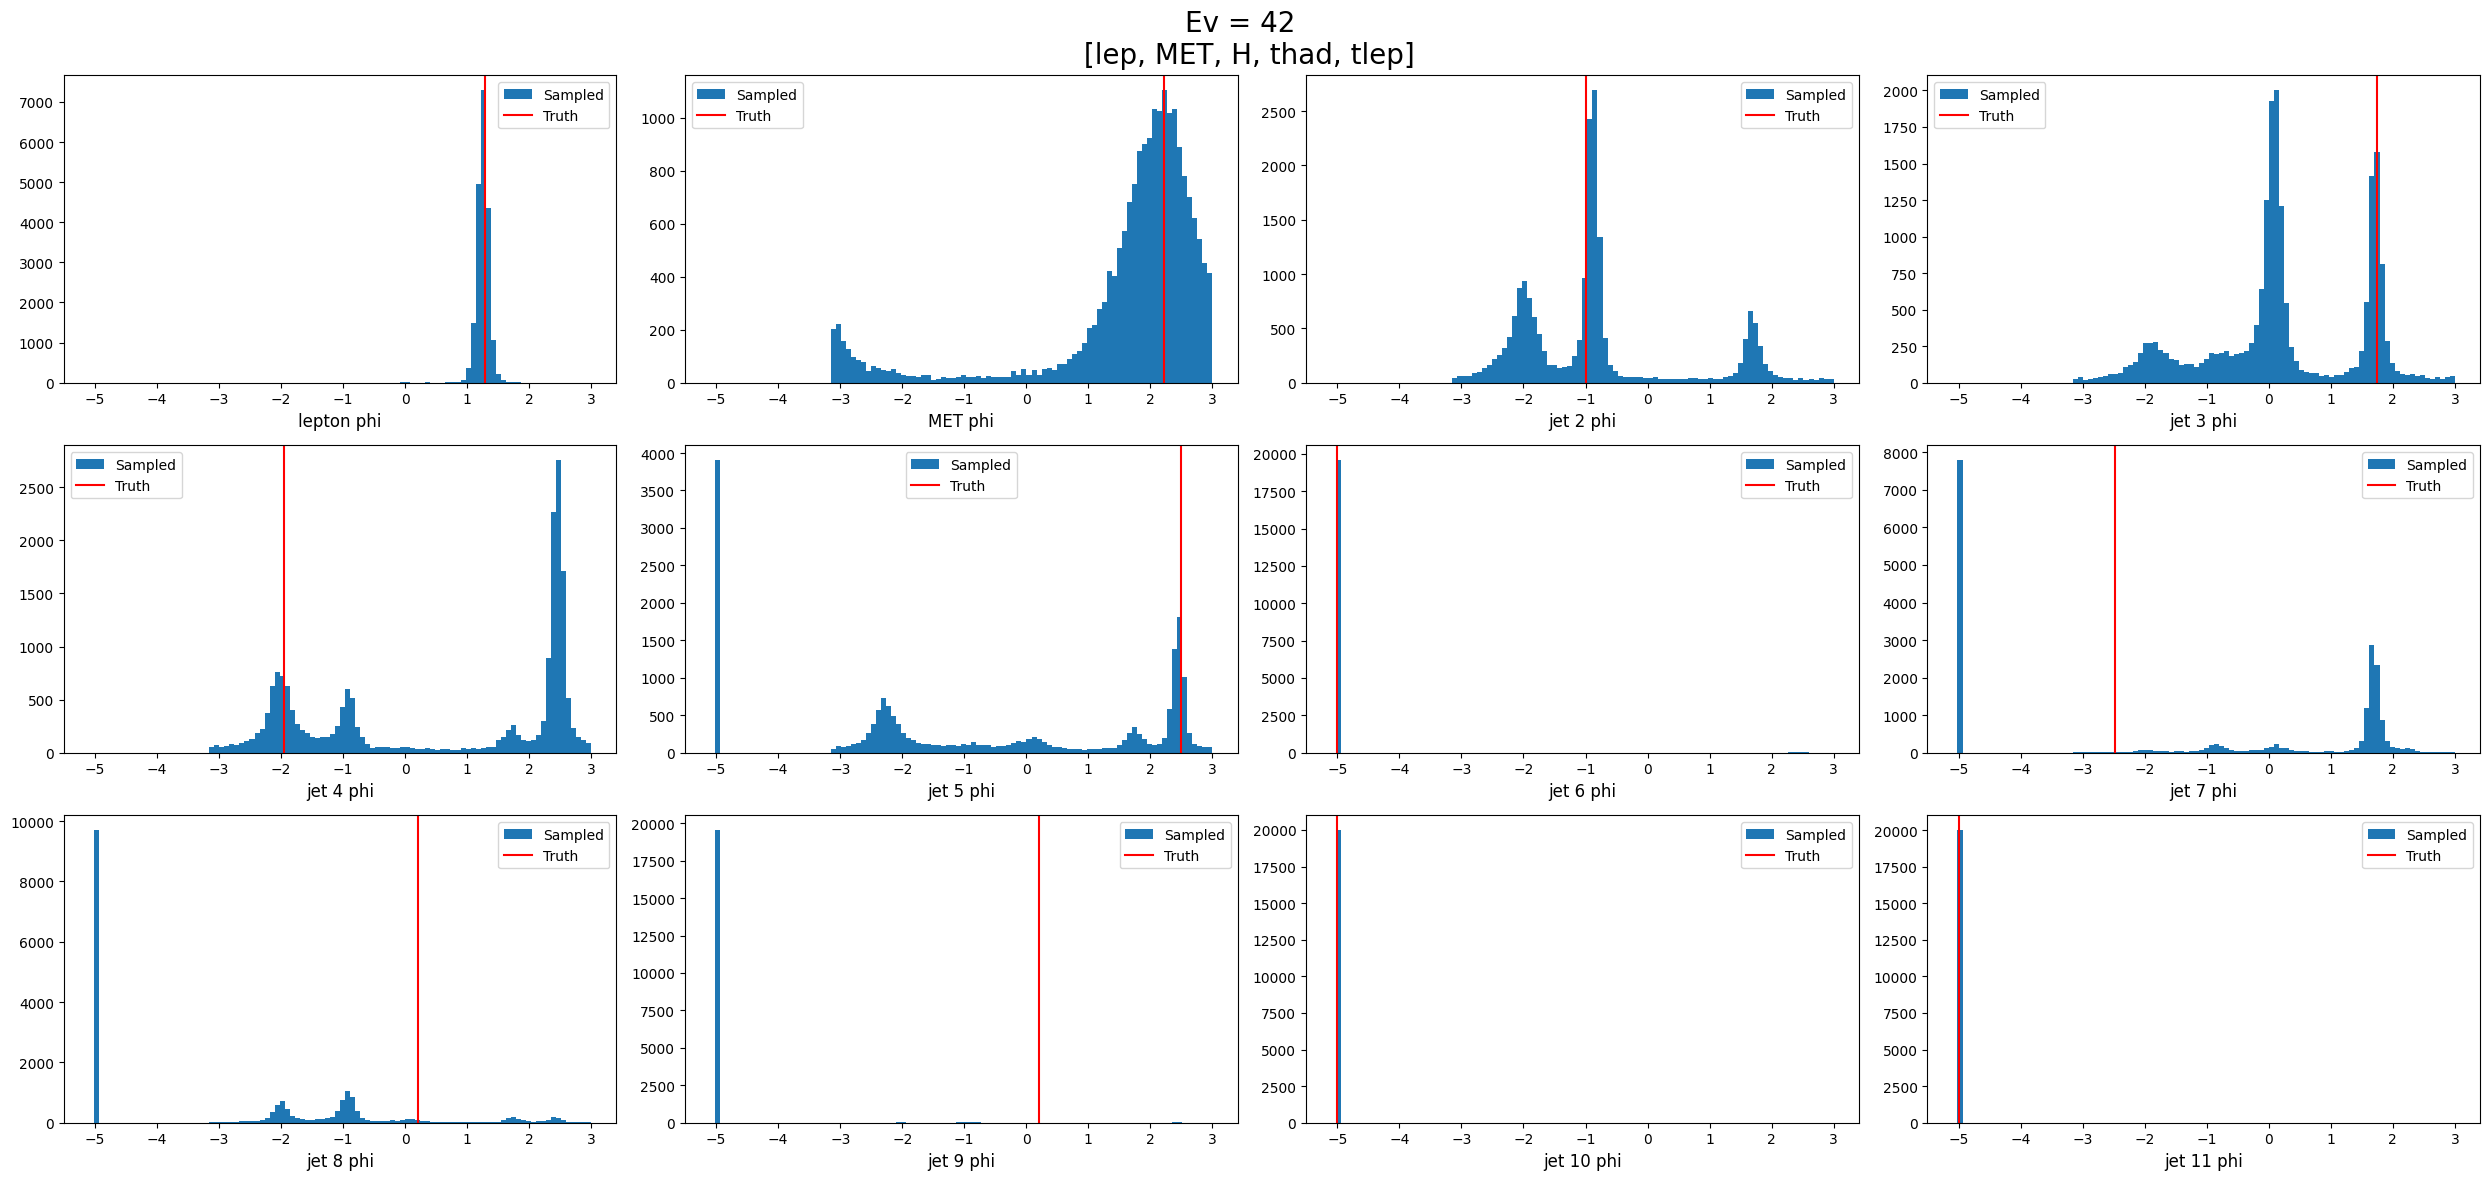

In [16]:
maxNoEv = sampledEvent.shape[0]
randomEv = random.randint(0, maxNoEv)
old_order = 2
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-5.1,200),
                               evNo=randomEv, var='pt', noObjs=12, old_order=old_order)
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-5.1,3),
                               evNo=randomEv, var='eta', noObjs=12, old_order=old_order)
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-5.1,3),
                               evNo=randomEv, var='phi', noObjs=12, old_order=old_order)

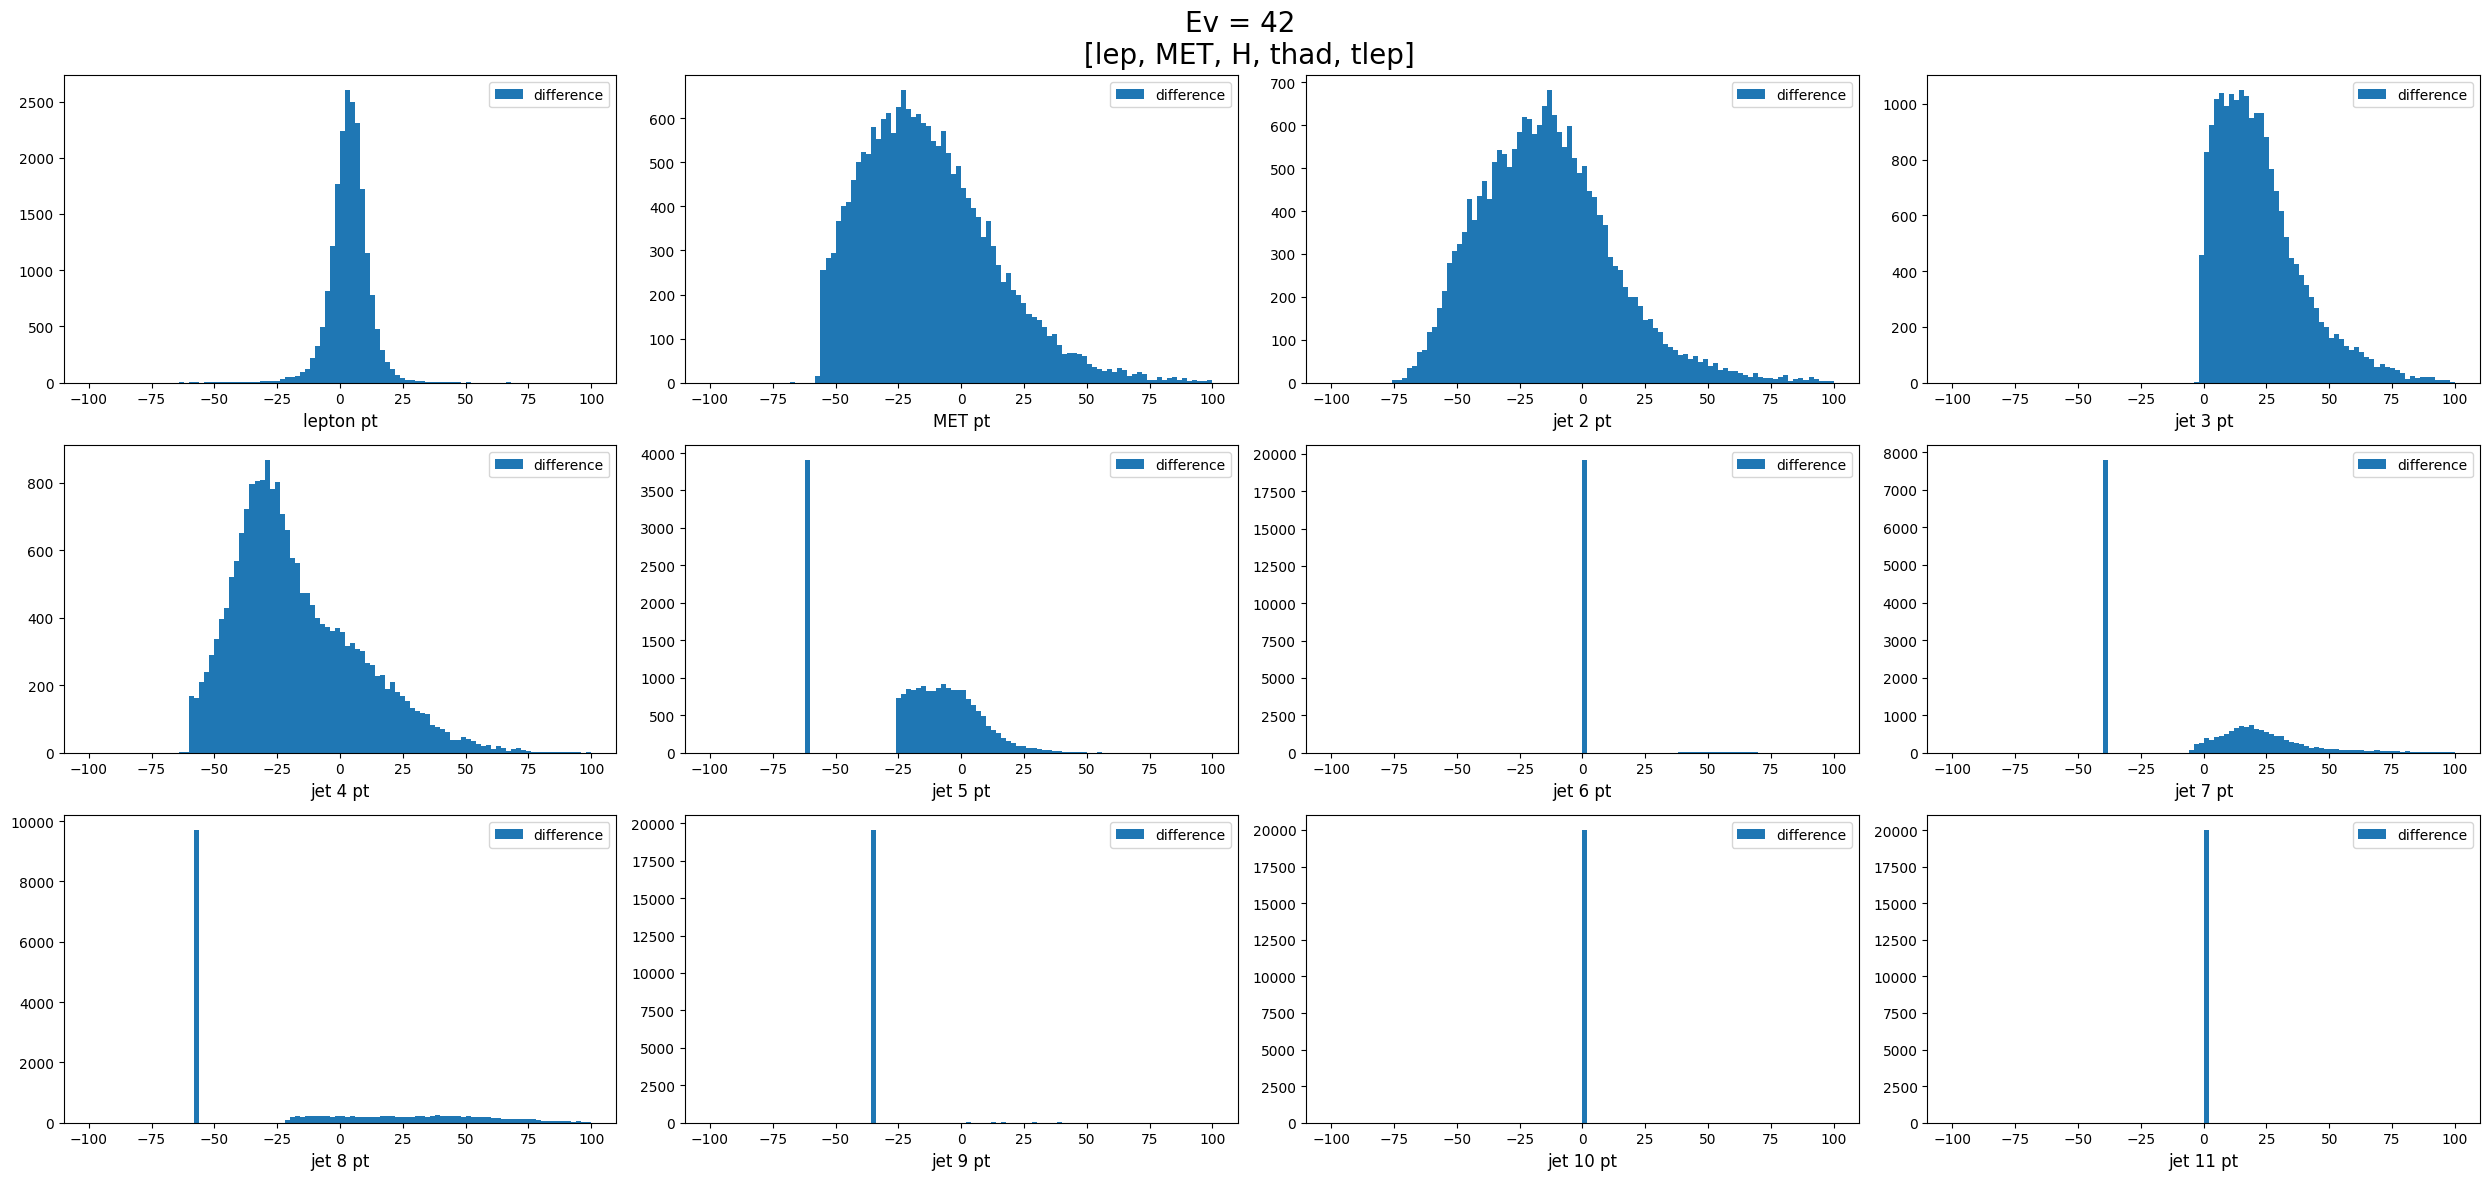

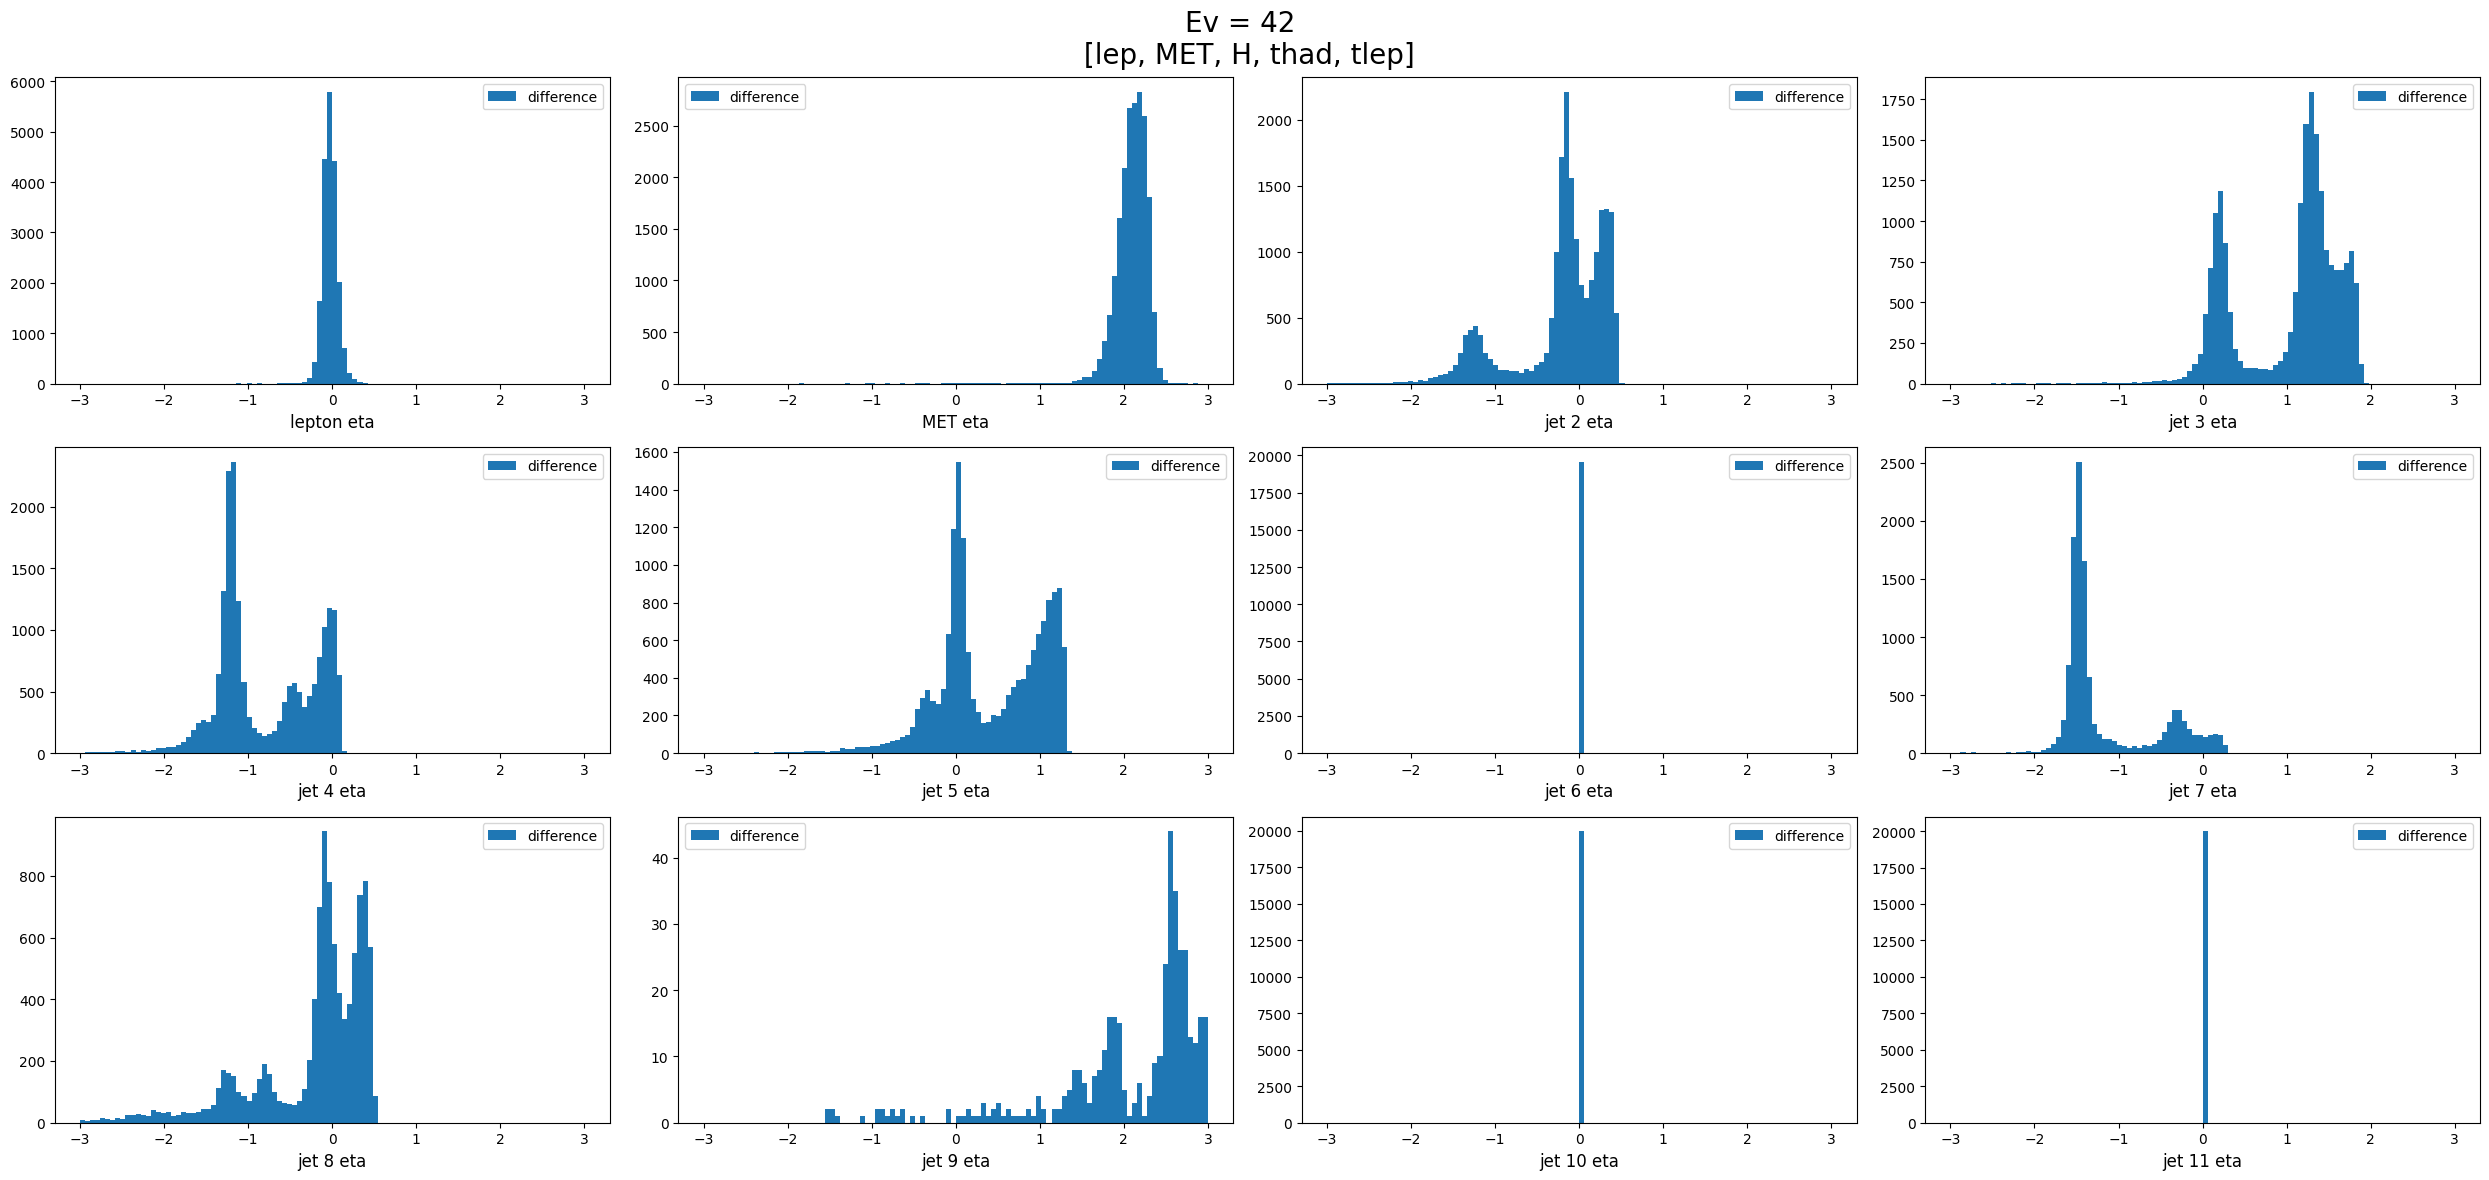

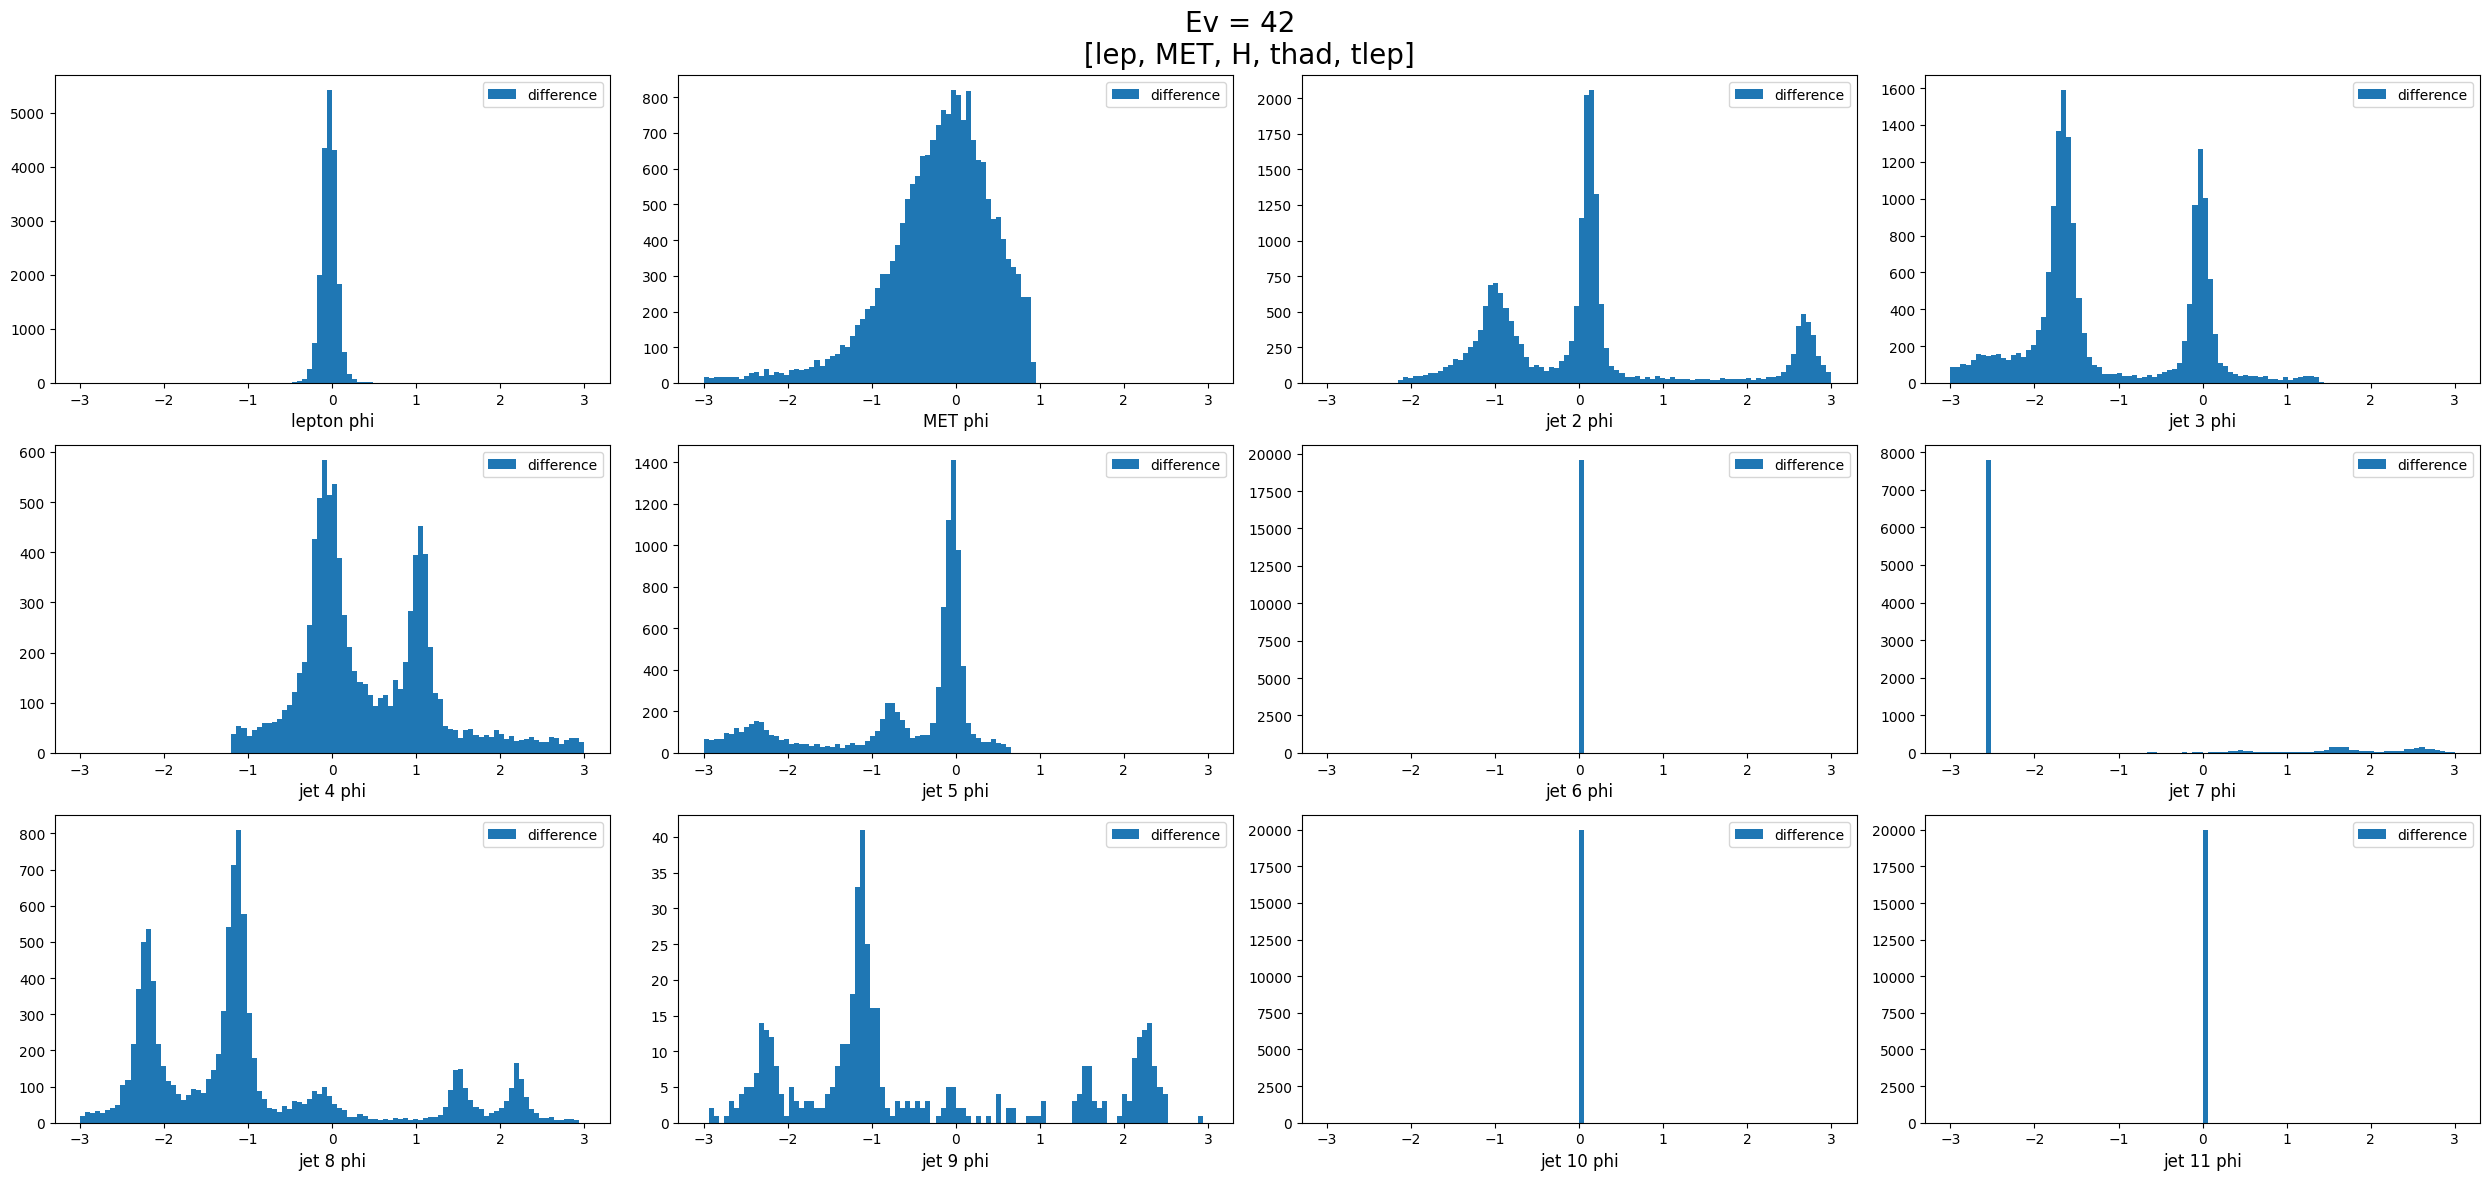

In [17]:
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-100,100),
                               evNo=randomEv, var='pt', noObjs=12, old_order=old_order, difference=True)
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-3,3),
                               evNo=randomEv, var='eta', noObjs=12, old_order=old_order, difference=True)
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-3,3),
                               evNo=randomEv, var='phi', noObjs=12, old_order=old_order, difference=True)

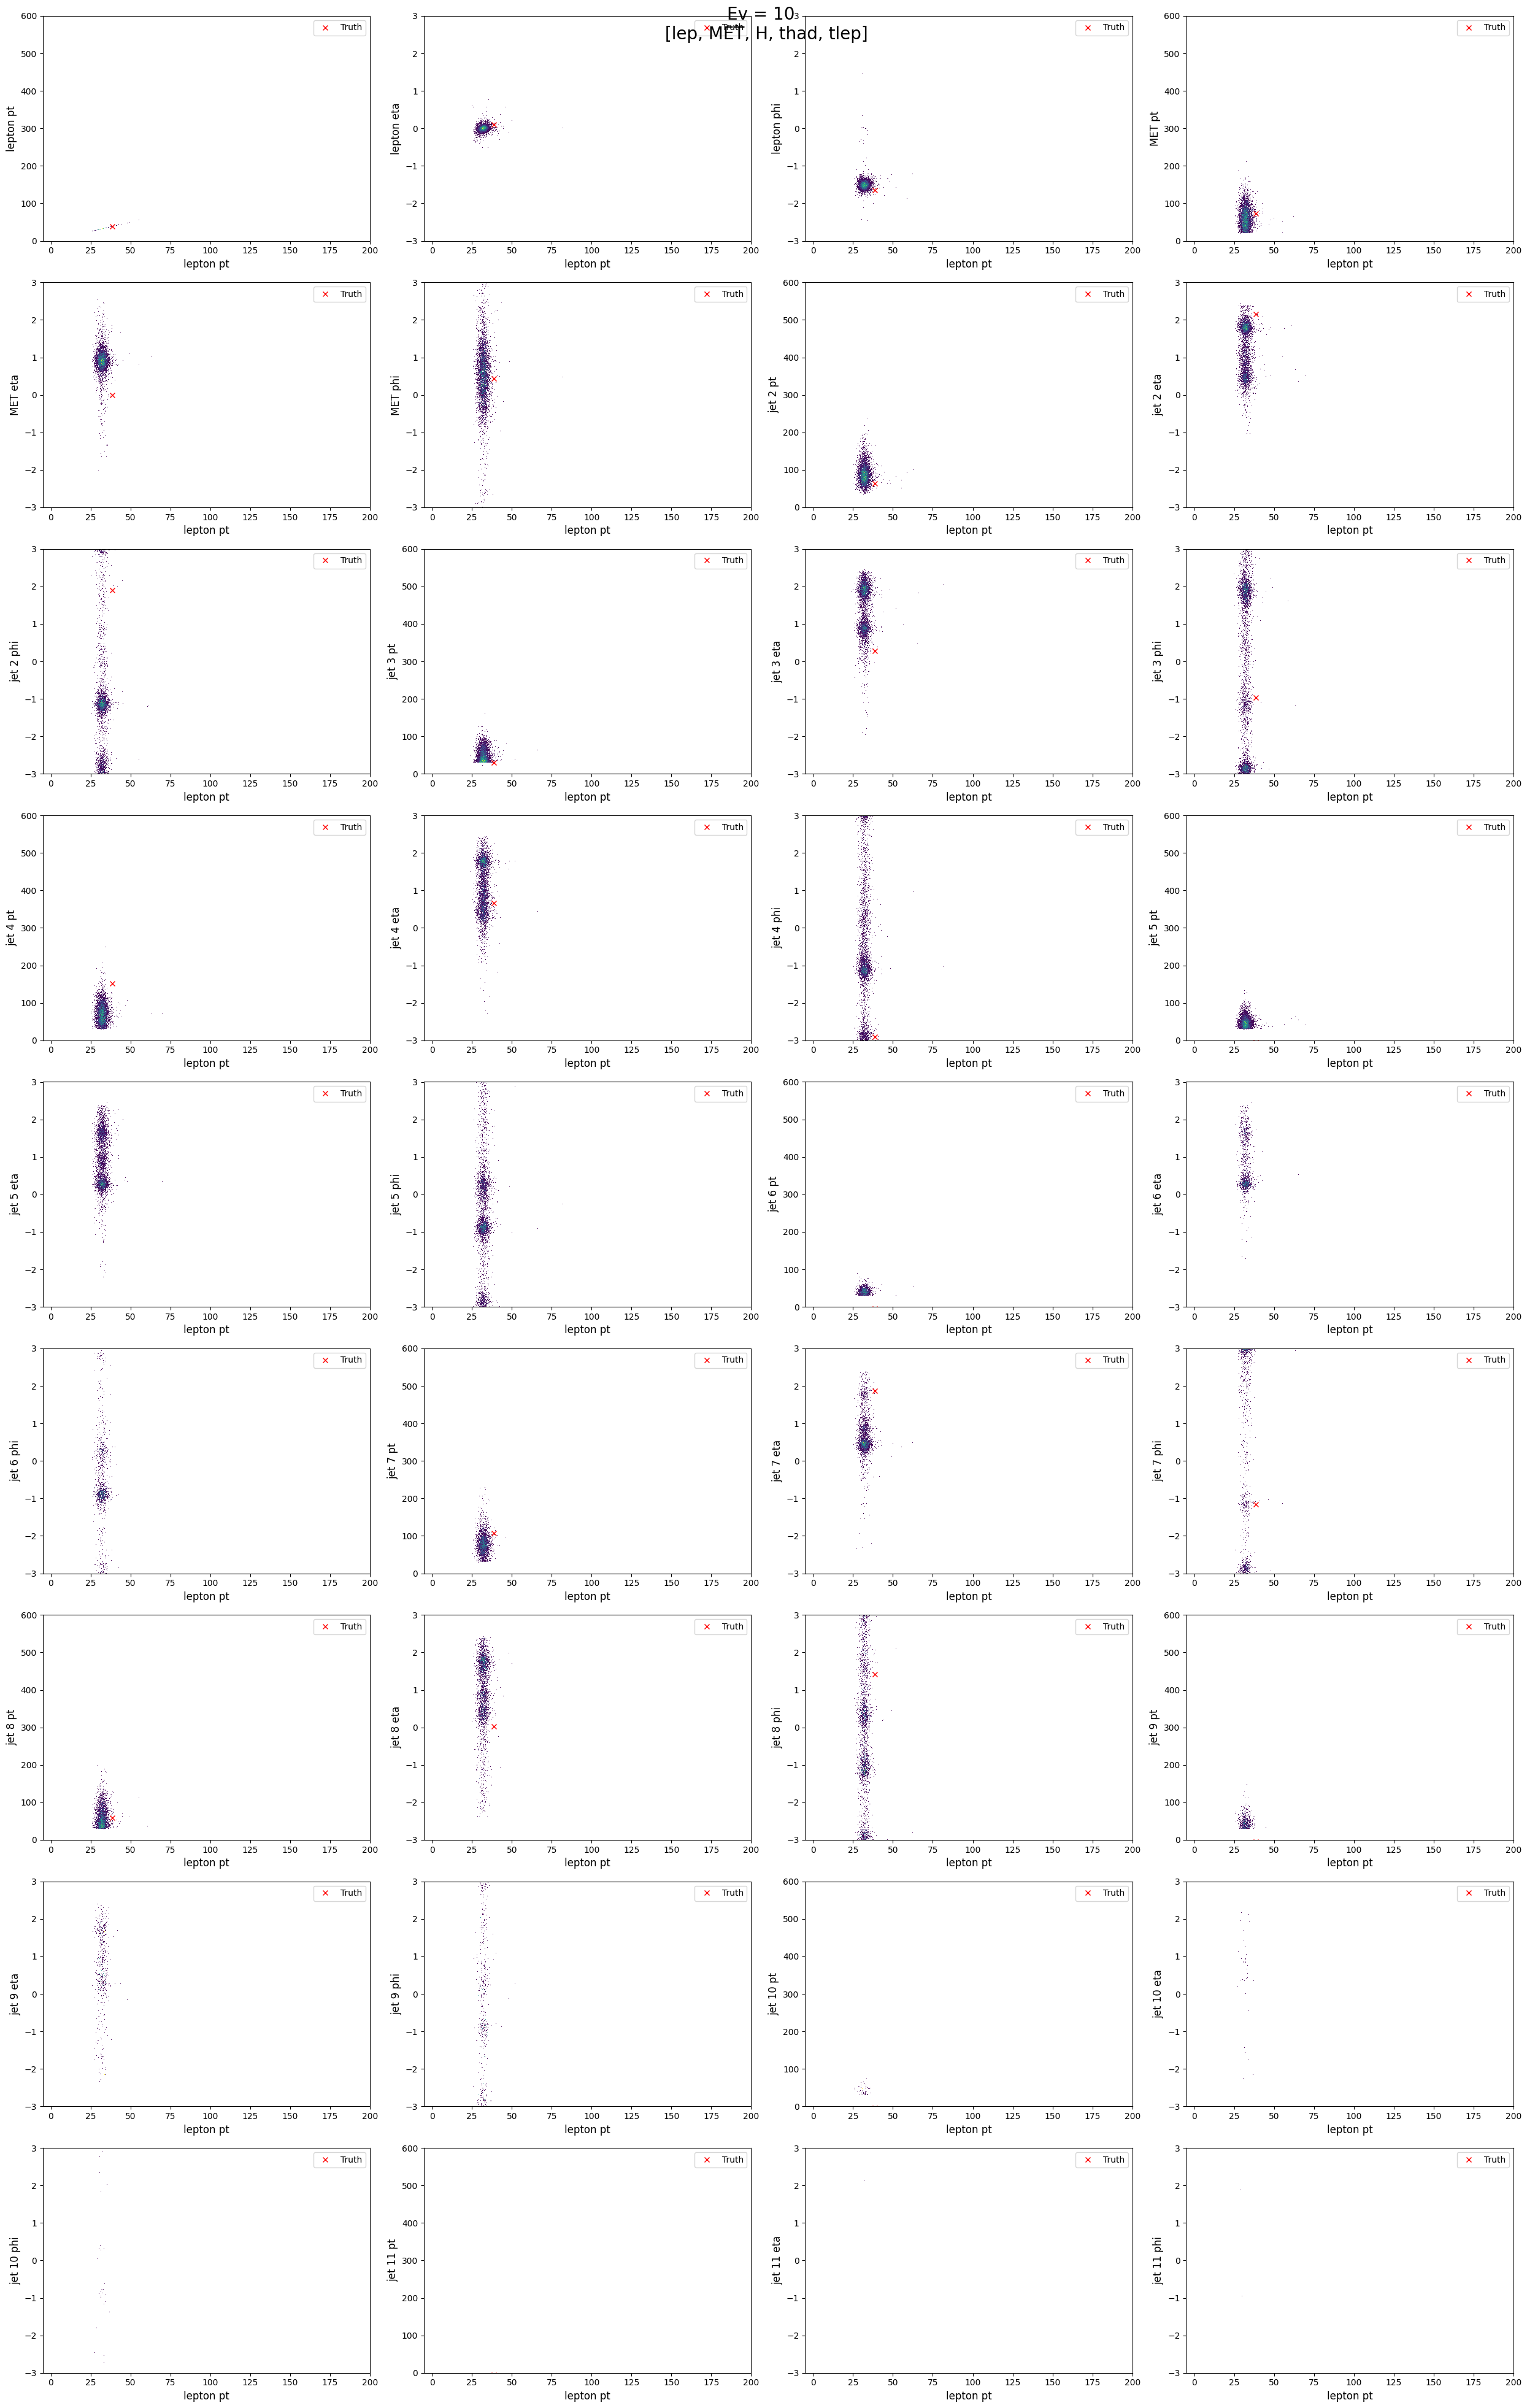

In [18]:
sampling_print_oneEvent_2Dcorr(sampledEvent[:,1:], targetEvent=sampledEvent[:,0], evNo=10, jetNo=0, var='pt',
                                   noObjs=12, range_x=(-5.1,200), xlabel='x', ylabel='y', old_order=old_order)

# Bias + Uncertainty

In [15]:
print(sampledAllEvent[:,1:,0,1].shape)
print(sampledAllEvent[:,0,0,1].shape)

torch.Size([1792000, 30])
torch.Size([1792000])


In [16]:
from numba import jit
@jit(nopython=True)
def get_central_smallest_interval(array, xrange, nbins, Ntrial=10000, perc=0.68):
    H = np.histogram(array, bins=nbins, range=xrange)
    # trying to smooth out noisy histo

    leftBin = np.argmax(H[0]) - 5
    if leftBin < 0:
        leftBin = 0

    rightBin = np.argmax(H[0]) + 5
    if rightBin > H[1].shape[0]:
        rightBin = H[1].shape[0] - 1

    xmax_l = H[1][leftBin]
    xmax_h = H[1][rightBin]
    xmax = np.mean(array[(array>xmax_l)&(array<xmax_h)])
    
    deltax = (xrange[1]-xrange[0])/(2*Ntrial)

    absmax = np.quantile(array, 0.995)
    absmin = np.quantile(array, 0.005)
    
    N = array.shape[0]
    xd = xmax-deltax
    xu = xmax+deltax
    for i in range(Ntrial):
        q = np.sum((array>xd) &(array<xu))/ N
        if q>=perc: 
            break
        if xd > absmin:
            xd = xd-deltax
        if xu < absmax:
            xu = xu+deltax
    return xmax, xd, xu

import mplhep as hep
plt.style.use(hep.style.CMS)

def plot_diff_mode_quantile(Y, X, cat_var, bins,
                      xlabel='', ylabel='', title='', title_pos=(0.2,0.9),
                    debug=False,
                    xlim=None, ylim=None, nbins_mode=100, output_file=None):
    
    Y_mode  = []
    X_avg = []
    quantile_right_list = []
    quantile_left_list = []
    quantile_right_list_95 = []
    quantile_left_list_95 = []

    for i in range(len(bins)-1):
        mask = ((cat_var >= bins[i])&(cat_var< bins[i+1]))
        #print(mask)
        Ymask = Y[mask]
        X_avg.append(np.mean(X[mask]))

        #print((np.min(Ymask), np.max(Ymask)))
        print(bins[i])
        #print(bins[i+1])
        #print(Ymask.size//nbins_mode)
        
        mode, left, right = get_central_smallest_interval(Ymask, xrange=(np.quantile(Ymask, 0.03), np.quantile(Ymask, 0.97)),
                                      nbins=Ymask.size//nbins_mode, Ntrial=2000, perc=0.68)

        _, left95, right95 = get_central_smallest_interval(Ymask, xrange=(np.quantile(Ymask, 0.03), np.quantile(Ymask, 0.97)),
                                      nbins=Ymask.size//nbins_mode, Ntrial=2000, perc=0.95)
        #print(mode)
        #print()
        

        if debug:
            f = plt.figure()
            plt.hist(Ymask, range=(np.quantile(Ymask, 0.03), np.quantile(Ymask, 0.97)),   bins=Ymask.size//100, histtype="step")
            plt.axvline(left, c='r', label="0.68")
            plt.axvline(right, c='r')
            plt.axvline(left95, c='orange', label="0.95")
            plt.axvline(right95, c='orange')
            plt.axvline(mode, label="mode", c="green")
            plt.title(f"Bins {bins[i]:.2f}-{bins[i+1]:.2}")
            plt.legend()
            plt.show()

        
        Y_mode.append(mode)
        quantile_left_list.append(left)
        quantile_right_list.append(right)
        quantile_left_list_95.append(left95)
        quantile_right_list_95.append(right95)
        #print(Y_mode, left, right)

    offset_left = np.array(Y_mode) - np.array(quantile_left_list) # need offset
    offset_right = np.array(quantile_right_list) - np.array(Y_mode)
    
    offset_left_95 = np.array(Y_mode) - np.array(np.array(quantile_left_list_95)) # need offset
    offset_right_95 = np.array(quantile_right_list_95) - np.array(Y_mode)

    f  = plt.figure(figsize=(7,6), dpi=150)
    ax = plt.gca()
    
    ax.plot(X_avg, Y_mode, linestyle='-', marker='o', color='k', label="mode")
    ax.grid(axis="y")
        
    ax.fill_between(X_avg, Y_mode - offset_left, Y_mode + offset_right,
                     color='r', alpha=0.2, label='68% CL')
    ax.fill_between(X_avg, Y_mode - offset_left_95, Y_mode + offset_right_95,
                     color='b', alpha=0.15, label='95% CL')
    ax.legend(facecolor='white',framealpha=1, fontsize=16 )
    ax.set_xlabel(xlabel, fontsize=17)
    ax.set_ylabel(ylabel, fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    ax.text(title_pos[0], title_pos[1], title, fontsize=20, transform=ax.transAxes)
    hep.cms.label(rlabel="13 TeV",  llabel="Simulation Preliminary", loc=0, ax=ax,fontsize=20)
    #if output_file:
        #plt.tight_layout()
        #plt.subplots_adjust(left=0.2, right=0.8)
        #plt.savefig(output_file +".png")
        #plt.savefig(output_file +".pdf")

In [17]:
diff_eta = sampledAllEvent[:,1:,0,1] - sampledAllEvent[:,0,0,1].unsqueeze(dim=1)
diff_eta_avgEachEvent = torch.mean(diff_eta, dim=1)
print(diff_eta.shape)
print(diff_eta_avgEachEvent.shape)

torch.Size([1792000, 30])
torch.Size([1792000])


1792000
tensor(True)
-4
-2
-1.5
-1.0
-0.5
-0.2
-0.0
0.2
0.5
1.0
1.5
2
tensor(True)
-4
-2
-1.5
-1.0
-0.5
-0.2
-0.0
0.2
0.5
1.0
1.5
2
tensor(True)
-4
-2
-1.5
-1.0
-0.5
-0.2
-0.0
0.2
0.5
1.0
1.5
2
tensor(False)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


-4


IndexError: index -1 is out of bounds for axis 0 with size 0

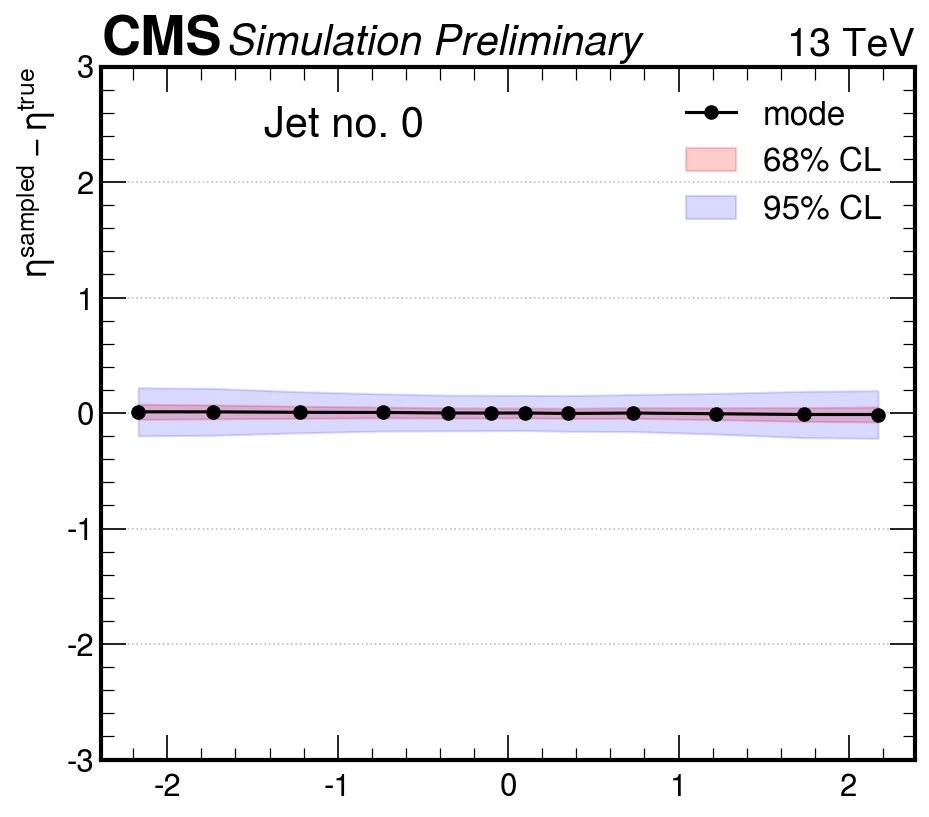

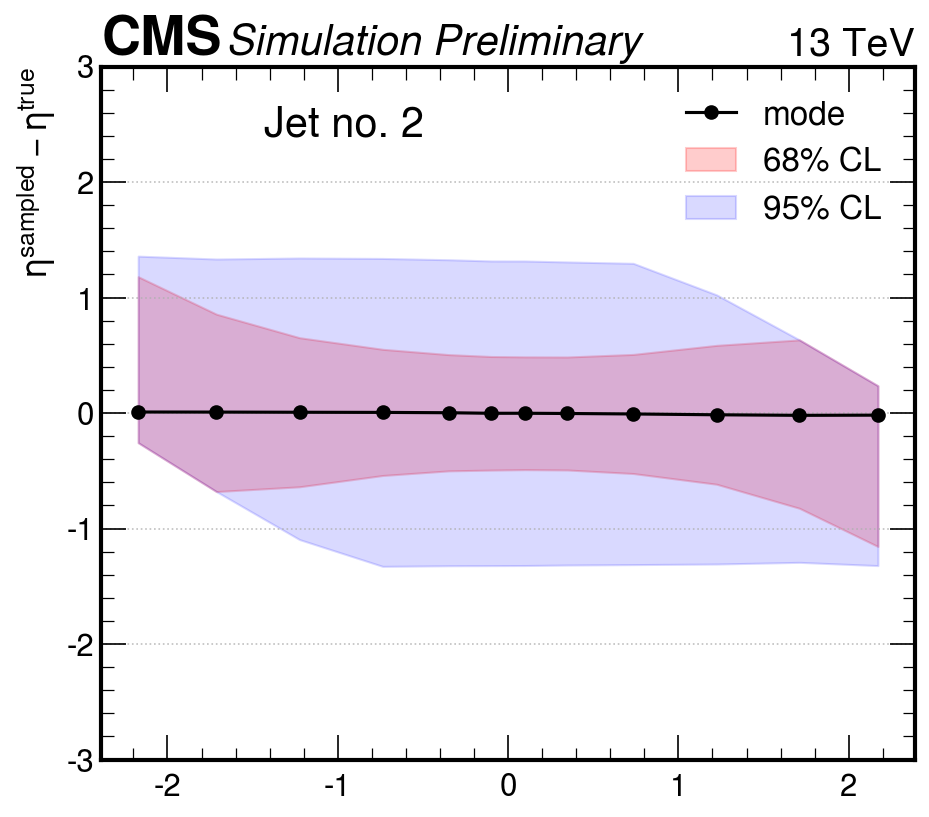

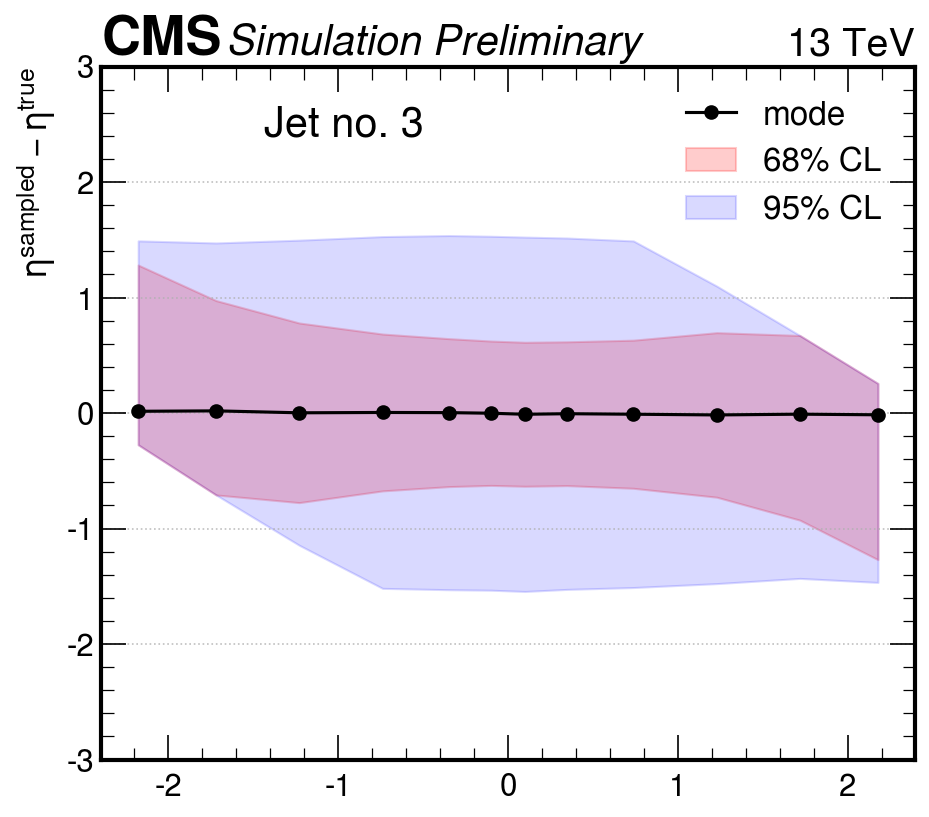

In [18]:
No_samples = 30
print(sampledAllEvent.size(0))

for jet in range(12):

    if jet == 1:
        continue

    maskExist = sampledAllEvent[:,0,jet,0] != -5
    maskExistSampled = sampledAllEvent[:,1:,jet,0] != -5

    no = torch.count_nonzero(torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled))
    print(no == torch.numel(maskExistSampled))
    #break

    #print(maskExist.shape)
    #print((sampledAllEvent[:,1:,jet,1] - sampledAllEvent[:,0,jet,1].unsqueeze(dim=1)).shape)
    #print(sampledAllEvent[:,1:,11,0])
    
    diff_eta = (sampledAllEvent[:,1:,jet,1] - sampledAllEvent[:,0,jet,1].unsqueeze(dim=1)) # sampled - target
    diff_eta = diff_eta[torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled)]
    diff_eta_flat = torch.flatten(diff_eta)
    
    #print(diff_eta_flat.shape)
    
    #print(diff_eta[1,0])
    #print(diff_eta[1,1])
    #print(sampledAllEvent[1,0,jet,1])

    targetEtaRepeated = (sampledAllEvent[:,0,jet,1]).unsqueeze(dim=1).repeat(1, No_samples)
    targetEtaRepeated = targetEtaRepeated[torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled)]
    targetEtaRepeated = torch.flatten(targetEtaRepeated)
    #targetEtaRepeated_2 = (sampledAllEvent[:,0,jet,1]).repeat_interleave(No_samples)
    #print(torch.all(targetEtaRepeated == targetEtaRepeated_2))
    #print(targetEtaRepeated.shape)

    #print()
    #print(diff_eta_flat[30])
    #print(diff_eta_flat[31])
    #print(targetEtaRepeated[30])
    #print(targetRepeated[31])
    
    plot_diff_mode_quantile(diff_eta_flat.numpy(), 
                            X=targetEtaRepeated.numpy(),  
                            cat_var=targetEtaRepeated.numpy(), 
                            bins=[-4, -2, -1.5, -1.0, -0.5, -0.2, -0., 0.2, 0.5, 1., 1.5, 2, 4],
                            xlabel='', ylim=(-3,3),
                            ylabel='$\eta^{sampled} - \eta^{true}$', title=f'Jet no. {jet}',nbins_mode=50)


In [ ]:
No_samples = 30
print(sampledAllEvent.size(0))

for jet in range(12):

    if jet > 5:
        continue

    maskExist = sampledAllEvent[:,0,jet,0] != -5
    maskExistSampled = sampledAllEvent[:,1:,jet,0] != -5

    diff_phi = sampledAllEvent[:,1:,jet,2] - sampledAllEvent[:,0,jet,2].unsqueeze(dim=1) # sampled - target
    
    #print(sampledAllEvent[0,1:,jet,2])
    #print(sampledAllEvent[0,0,jet,2])
    

    diff_phi = diff_phi[torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled)]
    diff_phi_flat = torch.flatten(diff_phi)
    mask_larger = diff_phi_flat > torch.pi
    mask_lower = diff_phi_flat < -1*torch.pi
    diff_phi_flat[mask_larger] = diff_phi_flat[mask_larger] - 2*torch.pi
    diff_phi_flat[mask_lower] = diff_phi_flat[mask_lower] + 2*torch.pi

    print(torch.min(diff_phi_flat))
    print(torch.max(diff_phi_flat))
    
    #print(diff_phi)
    #break
    #print(diff_eta[1,0])
    #print(diff_eta[1,1])
    #print(sampledAllEvent[1,0,jet,1])

    targetPhiRepeated = sampledAllEvent[:,0,jet,2].unsqueeze(dim=1).repeat(1, No_samples)
    targetPhiRepeated = targetPhiRepeated[torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled)]
    targetPhiRepeated = torch.flatten(targetPhiRepeated)
    

    #print()
    #print(diff_eta_flat[30])
    #print(diff_eta_flat[31])
    #print(targetRepeated[30])
    #print(targetRepeated[31])
    
    plot_diff_mode_quantile(diff_phi_flat.numpy(), 
                            X=targetPhiRepeated.numpy(),  
                            cat_var=targetPhiRepeated.numpy(), 
                            bins=[-3.14,-2.,-1.5, -1.0, 
                                   -0.7, -0.4, -0.2, -0., 0.2,0.4, 0.7,
                                   1., 1.5, 2., 3.14],
                            xlabel='', ylim=(-3,3),
                            ylabel='$\phi^{sampled} - \phi^{true}$', title=f'Jet no. {jet}',nbins_mode=50)


In [ ]:
No_samples = 30
print(sampledAllEvent.size(0))

for jet in range(12):

    if jet < 6:
        continue

    maskExist = sampledAllEvent[:,0,jet,0] != -5
    maskExistSampled = sampledAllEvent[:,1:,jet,0] != -5

    diff_phi = sampledAllEvent[:,1:,jet,2] - sampledAllEvent[:,0,jet,2].unsqueeze(dim=1) # sampled - target
    
    #print(sampledAllEvent[0,1:,jet,2])
    #print(sampledAllEvent[0,0,jet,2])
    

    diff_phi = diff_phi[torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled)]
    diff_phi_flat = torch.flatten(diff_phi)

    print(torch.min(diff_phi_flat))
    print(torch.max(diff_phi_flat))
    mask_larger = diff_phi_flat > torch.pi
    mask_lower = diff_phi_flat < -1*torch.pi
    diff_phi_flat[mask_larger] = diff_phi_flat[mask_larger] - 2*torch.pi
    diff_phi_flat[mask_lower] = diff_phi_flat[mask_lower] + 2*torch.pi
    
    #print(diff_phi)
    #break
    #print(diff_eta[1,0])
    #print(diff_eta[1,1])
    #print(sampledAllEvent[1,0,jet,1])

    targetPhiRepeated = sampledAllEvent[:,0,jet,2].unsqueeze(dim=1).repeat(1, No_samples)
    targetPhiRepeated = targetPhiRepeated[torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled)]
    targetPhiRepeated = torch.flatten(targetPhiRepeated)
    

    #print()
    #print(diff_eta_flat[30])
    #print(diff_eta_flat[31])
    #print(targetRepeated[30])
    #print(targetRepeated[31])
    
    plot_diff_mode_quantile(diff_phi_flat.numpy(), 
                            X=targetPhiRepeated.numpy(),  
                            cat_var=targetPhiRepeated.numpy(), 
                            bins=[-3.14,-2.,-1.5, -1.0, 
                                   -0.7, -0.4, -0.2, -0., 0.2,0.4, 0.7,
                                   1., 1.5, 2., 3.14],
                            xlabel='', ylim=(-3,3),
                            ylabel='$\phi^{sampled} - \phi^{true}$', title=f'Jet no. {jet}',nbins_mode=50)


In [ ]:
No_samples = 30
print(sampledAllEvent.size(0))

for jet in range(6):

    maskExist = sampledAllEvent[:,0,jet,0] != -5
    maskExistSampled = sampledAllEvent[:,1:,jet,0] != -5

    ratio_pt = (sampledAllEvent[:,1:,jet,0] - sampledAllEvent[:,0,jet,0].unsqueeze(dim=1))/sampledAllEvent[:,0,jet,0].unsqueeze(dim=1) # sampled - target
    ratio_pt = ratio_pt[torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled)]
    ratio_pt_flat = torch.flatten(ratio_pt)

    #print(diff_eta[1,0])
    #print(diff_eta[1,1])
    #print(sampledAllEvent[1,0,jet,1])

    targetPtRepeated = sampledAllEvent[:,0,jet,0].unsqueeze(dim=1).repeat(1, No_samples)
    targetPtRepeated = targetPtRepeated[torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled)]
    targetPtRepeated = torch.flatten(targetPtRepeated)

    q = torch.linspace(0,1,21)
    if jet > 4:
        q = torch.linspace(0,1,11)
    quantiles = torch.quantile(sampledAllEvent[:,0,jet,0][maskExist], q)
    
    plot_diff_mode_quantile(ratio_pt_flat.numpy(), 
                            X=targetPtRepeated.numpy(),  
                            cat_var=targetPtRepeated.numpy(), 
                            bins=quantiles.tolist(), 
                            xlabel='', ylim=(-3,3),
                            ylabel='$(pt^{sampled} - pt^{true})/pt^{true}$', title=f'Jet no. {jet}',nbins_mode=50)


In [ ]:
No_samples = 30
print(sampledAllEvent.size(0))

for jet in range(6, 12):

    maskExist = sampledAllEvent[:,0,jet,0] != -5
    maskExistSampled = sampledAllEvent[:,1:,jet,0] != -5

    ratio_pt = (sampledAllEvent[:,1:,jet,0] - sampledAllEvent[:,0,jet,0].unsqueeze(dim=1))/sampledAllEvent[:,0,jet,0].unsqueeze(dim=1) # sampled - target
    ratio_pt = ratio_pt[torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled)]
    ratio_pt_flat = torch.flatten(ratio_pt)

    #print(diff_eta[1,0])
    #print(diff_eta[1,1])
    #print(sampledAllEvent[1,0,jet,1])

    targetPtRepeated = sampledAllEvent[:,0,jet,0].unsqueeze(dim=1).repeat(1, No_samples)
    targetPtRepeated = targetPtRepeated[torch.logical_and(maskExist.unsqueeze(dim=1), maskExistSampled)]
    targetPtRepeated = torch.flatten(targetPtRepeated)

    q = torch.linspace(0,1,21)
    if jet > 4:
        q = torch.linspace(0,1,11)
    quantiles = torch.quantile(sampledAllEvent[:,0,jet,0][maskExist], q)
    
    plot_diff_mode_quantile(ratio_pt_flat.numpy(), 
                            X=targetPtRepeated.numpy(),  
                            cat_var=targetPtRepeated.numpy(), 
                            bins=quantiles.tolist(), 
                            xlabel='', ylim=(-3,3),
                            ylabel='$(pt^{sampled} - pt^{true})/pt^{true}$', title=f'Jet no. {jet}',nbins_mode=50)


# calibration plots 

In [ ]:
for jet in range(12):
    pt_target = sampledAllEvent[:,0,jet,0]
    q = torch.linspace(0,1,21)
    if jet > 4:
        q = torch.linspace(0,1,11)
    #print(q)
    #print(pt_target.shape)

    mask_exist_target = sampledAllEvent[:,0,jet,0] > -5
    mask_exist_sampled = sampledAllEvent[:,1:,jet,0] > -5
    
    quantiles = torch.quantile(pt_target[mask_exist_target], q)
    print(quantiles)
    total_samples = torch.numel(sampledAllEvent[:,1:,jet,0][mask_exist_sampled])
    #print(total_samples)
    
    samples_fraction = []
    for i in range(len(quantiles) - 1):
        pt_min = quantiles[0]
        pt_max = quantiles[i+1]
    
        mask_lower = sampledAllEvent[:,1:,jet,0][mask_exist_sampled] >= pt_min
        mask_higher = sampledAllEvent[:,1:,jet,0][mask_exist_sampled] < pt_max
        final_mask = torch.logical_and(mask_lower, mask_higher)
    
        #print(torch.count_nonzero(final_mask)/total_samples)
        samples_fraction.append(torch.count_nonzero(final_mask)/total_samples)

    plt.plot(q[1:], samples_fraction, '-o', label='samples')
    plt.plot(q, q, '--', color='k', label='target')
    plt.xlabel('quantile pt')
    plt.ylabel('fraction sampled events')
    plt.title(f'{jet}')
    plt.show()
    


In [ ]:
a = torch.Tensor([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
q = torch.Tensor([0,0.1,0.3,0.8,1.0])
print(torch.quantile(a,q))